# 準備

In [1]:
Sys.setlocale('LC_ALL', 'ja_JP.UTF-8')
options(repr.plot.width = 15, repr.plot.height = 9)  ## 画像サイズの設定
options(warn = -1)                                   ## warningの非表示（表示は0にする）

# パッケージの読込み
library(tidyverse)
library(tsibble)
library(scales)
library(CausalImpact)
library(patchwork)

theme_set(theme_classic(base_family = 'HiraKakuPro-W3') +
  theme(plot.title = element_text(size = 15)
        , axis.title = element_text(size = 12)
        , axis.text = element_text(size = 8)
        , legend.title = element_text(size = 10)
        , legend.text = element_text(size = 8)))

[1] "ja_JP.UTF-8/ja_JP.UTF-8/ja_JP.UTF-8/C/ja_JP.UTF-8/C"

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibble.grouped_df dplyr


次のパッケージを付け加えます: ‘tsibble’


以下のオブジェクトは ‘package:lubridate’ からマスクされています:

    interval


以下のオブジェクトは ‘package:base’ からマスクされています:

    intersect, setdiff, union



次のパッケージを付け加えます: ‘scales’


以下のオブジェクトは ‘package:purrr’ からマスクされています:

    discard


以下のオブジェクトは ‘package:readr’ からマスクされています:

    col_factor


要求されたパッケージ bsts をロード中です

要求されたパッケージ BoomSpikeSlab をロード中です

要求されたパッケー

# 結果確認用の関数定義

In [2]:
# outcum（y.cf_true, y）と共変量（covariate）のplot
# ===========================================================================================
func_plot_check <- function(df) {
  
  # 共有のテーマを設定
  common_x_scale <- scale_x_date(date_breaks = '2 week'
                                 , date_labels = '%Y-%m-%d'
                                 # , minor_breaks = '1 week'
                                )

  common_theme <- theme(axis.title.x = element_blank()
                        # , axis.text.x = element_text(angle = 30, hjust = 1)
                        , axis.title.y = element_blank()
                        , legend.position = 'top'
                        , legend.title = element_blank()
                       )
  
  # データを横持ちから縦持ちに変換
  data_longer <- df |>
    tidyr::pivot_longer(cols = -date
                        , names_to = 'series'
                        , values_to = 'effect'
                       )
  
  # plot
  ## outcomeのplot
  plot_outcome <- data_longer |>
    dplyr::filter(series != 'covariate') |>
    ggplot(mapping = aes(x = date, y = effect, color = series)) +
      geom_vline(xintercept = ymd(pre_end_date)
                , linetype = 'dashed'
                , size = 1.0
                , color = 'grey'
                ) +
      geom_line(mapping = aes(linetype = series), size = 1.0) +
      scale_linetype_manual(values = c('solid', 'dashed')) +
			scale_color_manual(values = c('#00AA14', '#6C9BD2')) +
      common_x_scale +
      common_theme +
      labs(title = 'outcome')

  ## 共変量のplot
  plot_covariate <- data_longer |>
    dplyr::filter(series == 'covariate') |>
    ggplot(mapping = aes(x = date, y = effect, color = series)) +
      geom_vline(xintercept = ymd(pre_end_date)
                 , linetype = 'dashed'
                 , size = 1.0
                 , color = 'grey'
                ) +
      geom_line(size = 1.0) +
      scale_color_manual(values = c('#ee82ee')) +
      common_x_scale +
      common_theme +
      labs(title = 'covariate')
  

  # 返り値
  return(plot_outcome / plot_covariate)
}

In [3]:
func_plot_CIresult_diff_trueEffect <- function(data, impact, pre_end_date) {

  # データ読み込みと加工
	# ===========================================================================================
  df.impact_result <- tibble::as_tibble(impact$series)
  df <- data
  df.merge <- dplyr::bind_cols(df, df.impact_result)

  df.merge <- df.merge |>
    dplyr::mutate(across(c(y.cf_true, point.pred, point.pred.lower, point.pred.upper)
                        , ~ if_else(date <= pre_end_date, NA_real_, .), .names = '{col}_na'
                        )
								 ) |>
    dplyr::mutate(effect.true = y - y.cf_true) |>
    dplyr::mutate(across(c(effect.true, point.effect, point.effect.lower, point.effect.upper)
                        , ~ if_else(date <= pre_end_date, 0, .), .names = '{col}_zero'
                        )
                  ) |>
    dplyr::mutate(cum.effect.true = cumsum(y - y.cf_true))
	

	# plot2~4を描画するための関数
	# ===========================================================================================
  plot_effect <- function(data, y_cf_true, y_pred, ci_lower, ci_upper, title) {
		data |>
			ggplot(mapping = aes(x = date)) +
				#### 介入日 ####
				geom_vline(xintercept = ymd(pre_end_date), linetype = 'dashed', size = 1.0, color = 'grey')  +
				#### 95%信用区間 ####
				geom_ribbon(aes(ymin = .data[[ci_lower]], ymax = .data[[ci_upper]], fill = '95%信用区間'), alpha = 0.5) +
				#### 介入がなかった場合のyの予測値 ####
				geom_line(mapping = aes(y = .data[[y_pred]], linetype = '推定値'), color = 'black', size = 1.0, alpha = 0.7) +
				#### 介入がなかった場合のyの観測値 ※本来は観測できない ####
				geom_line(mapping = aes(y = .data[[y_cf_true]], linetype = '真の値'), color = '#6C9BD2', size = 1.0) +
				scale_fill_manual(values = c('95%信用区間' = 'lightgrey')) +
				scale_linetype_manual(values = c('真の値' = 'solid', '推定値' = 'dashed')) +
				guides(linetype = guide_legend(order = 1),
							fill = guide_legend(order = 2)) +
				scale_x_date(date_breaks = '2 week', date_labels = '%Y-%m-%d') +
				theme(axis.title.x = element_blank(),
							axis.title.y = element_blank(),
							legend.position = 'top',
							legend.title = element_blank()) +
				labs(title = title)
	}
  

  # 可視化
  # ===========================================================================================
  # plot1
  plot1 <- df.merge |>
		ggplot(mapping = aes(x = date)) +
			#### 介入日 ####
			geom_vline(xintercept = ymd(pre_end_date), linetype = 'dashed', size = 1.0, color = 'grey') +
			#### 推定値の95%信用区間 ####
			geom_ribbon(aes(ymin = point.pred.lower, ymax = point.pred.upper, fill = '95%信用区間'), alpha = 0.5) +
			#### point.pred：介入がなかった場合のyの予測値 ####
			geom_line(mapping = aes(y = point.pred, linetype = '推定値'), color = 'black', size = 1.0, alpha = 0.7) +
			#### y0：介入がなかった場合のyの観測値 ※本来は観測できない ####
			geom_line(mapping = aes(y = y.cf_true, linetype = '介入がなかった場合の値'), color = '#6C9BD2', size = 1.0) +
			#### y:yの観測値 ####
			geom_line(mapping = aes(y = y, linetype = '実際に観測された値'), color = '#00AA14', size = 1.0) +
			scale_fill_manual(values = c('95%信用区間' = 'lightgrey')) +
			scale_linetype_manual(values = c('介入がなかった場合の値' = 'solid', '実際に観測された値' = 'solid', '推定値' = 'dashed')) +
			guides(linetype = guide_legend(order = 1)
						, fill = guide_legend(order = 2)
						) +
			scale_x_date(date_breaks = '2 week'
									, date_labels = '%Y-%m-%d'
									) +
			theme(axis.title.x = element_blank()
						, axis.title.y = element_blank()
						, legend.position = 'top'
						, legend.title = element_blank()
					) +
			labs(title = 'outcome（実際に観測された値 / 介入がなかった場合の値 / 推定値）')

	# plot2
	plot2 <- df.merge |>
	  ggplot(mapping = aes(x = date)) +
		  #### 介入日 ####
			geom_vline(xintercept = ymd(pre_end_date), linetype = 'dashed', size = 1.0, color = 'grey') +
			#### 共変量 ####
			geom_line(mapping = aes(y = covariate, linetype = '共変量'), color = '#ee82ee', size = 1.0, alpha = 0.7) +
			scale_x_date(date_breaks = '2 week'
									, date_labels = '%Y-%m-%d'
									) +
			theme(axis.title.x = element_blank()
						, axis.title.y = element_blank()
						, legend.position = 'top'
						, legend.title = element_blank()) +
      labs(title = '共変量')
	# plot2 <- plot_effect(data = df.merge
	# 										, y_cf_true = 'y.cf_true_na'
	# 										, y_pred = 'point.pred_na'
	# 										, ci_lower = 'point.pred.lower_na'
	# 										, ci_upper = 'point.pred.upper_na'
	# 										, title = '真の値と推定値'
	# 									)
	
	# plot3
	plot3 <- plot_effect(data = df.merge
											, y_cf_true = 'effect.true_zero'
											, y_pred = 'point.effect_zero'
											, ci_lower = 'point.effect.lower_zero'
											, ci_upper = 'point.effect.upper_zero'
											, title = '効果（差分）'
										)
	
	# plot4
	plot4 <- plot_effect(data = df.merge
											, y_cf_true = 'cum.effect.true'
											, y_pred = 'cum.effect'
											, ci_lower = 'cum.effect.lower'
											, ci_upper = 'cum.effect.upper'
											, title = '累積効果'
										)
	
	return((plot1 + plot2) / (plot3 + plot4))
}

# 公式チュートリアル

In [4]:
# データ作成
set.seed(1)
n <- 100
covariate <- 100 + arima.sim(model = list(ar = 0.999), n = 100)  ## 公式チュートリアルでは'x1'と表記されている
y.cf_true <- 1.2 * covariate + rnorm(n)                          ## 介入がなかった場合のyの真の値を設定 ※本来は観測できない(cf = counterfactual)

pre_start_date <- lubridate::ymd('2024-10-01')

data <- cbind(y.cf_true, covariate) |>
  tibble::as_tibble() |>
  dplyr::mutate(date = seq.Date(pre_start_date, by = '1 day', length.out = n)) |>
  dplyr::select(date, y.cf_true, covariate) |>
  tsibble::as_tsibble(index = date)

In [5]:
# 介入時期の設定
pre_end_date <- pre_start_date + 69             ## 2024-12-09
post_start_date <- pre_start_date + 70          ## 2024-12-10
post_end_date <- pre_start_date + 99            ## 2025-01-08

pre.period <- c(pre_start_date, pre_end_date)
post.period <- c(post_start_date, post_end_date)

In [6]:
data.tutorial <- data |>
  dplyr::mutate(y = if_else(date >= post_start_date, y.cf_true + 10, y.cf_true)) |>
  dplyr::select(date, y.cf_true, y, covariate)

head(data.tutorial)
tail(data.tutorial)

date       y.cf_true y        covariate
1 2024-10-01 105.2950  105.2950 88.21513 
2 2024-10-02 105.8943  105.8943 88.48415 
3 2024-10-03 106.6209  106.6209 87.87684 
4 2024-10-04 106.1572  106.1572 86.77954 
5 2024-10-05 101.2812  101.2812 84.62243 
6 2024-10-06 101.4484  101.4484 84.60650

date       y.cf_true y        covariate
1 2025-01-03 105.2148  115.2148 88.23930 
2 2025-01-04 104.9429  114.9429 87.44356 
3 2025-01-05 106.6694  116.6694 86.95103 
4 2025-01-06 102.5801  112.5801 85.43364 
5 2025-01-07 101.3394  111.3394 85.65532 
6 2025-01-08 104.3264  114.3264 85.10503

In [7]:
# CausalImpactの実行
set.seed(1)
impact.tutorial <- CausalImpact::CausalImpact(data = data.tutorial |> dplyr::select(date, y, covariate)
																							, pre.period = pre.period
																							, post.period = post.period
																						 )

Posterior inference {CausalImpact}

                         Average        Cumulative  
Actual                   117            3511        
Prediction (s.d.)        107 (0.35)     3196 (10.48)
95% CI                   [106, 107]     [3175, 3218]
                                                    
Absolute effect (s.d.)   11 (0.35)      315 (10.48) 
95% CI                   [9.8, 11]      [293.6, 336]
                                                    
Relative effect (s.d.)   9.9% (0.36%)   9.9% (0.36%)
95% CI                   [9.1%, 11%]    [9.1%, 11%] 

Posterior tail-area probability p:   0.00101
Posterior prob. of a causal effect:  99.8993%

For more details, type: summary(impact, "report")



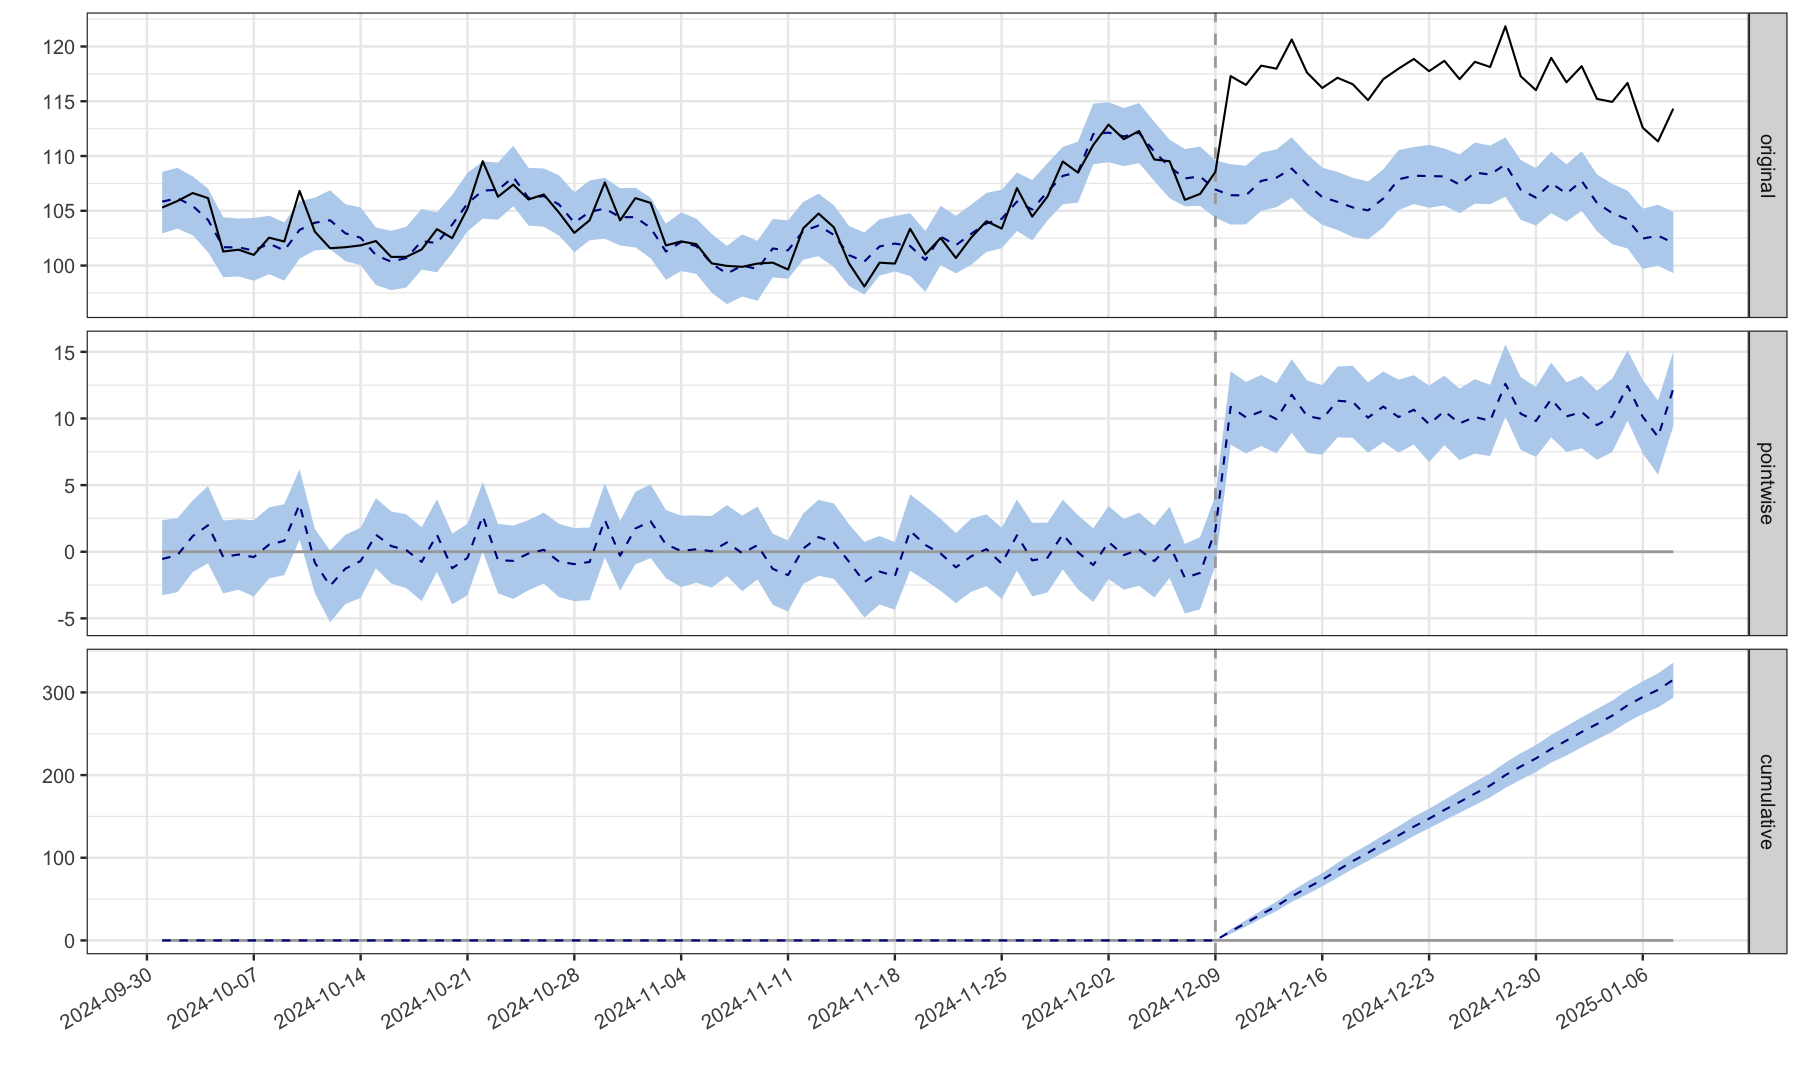

In [8]:
# CausalImpactの結果確認
summary(impact.tutorial)
plot(impact.tutorial) +
  scale_x_date(date_breaks = '1 week'
               , date_labels = '%Y-%m-%d'
               , minor_breaks = '1 week'
              ) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1))

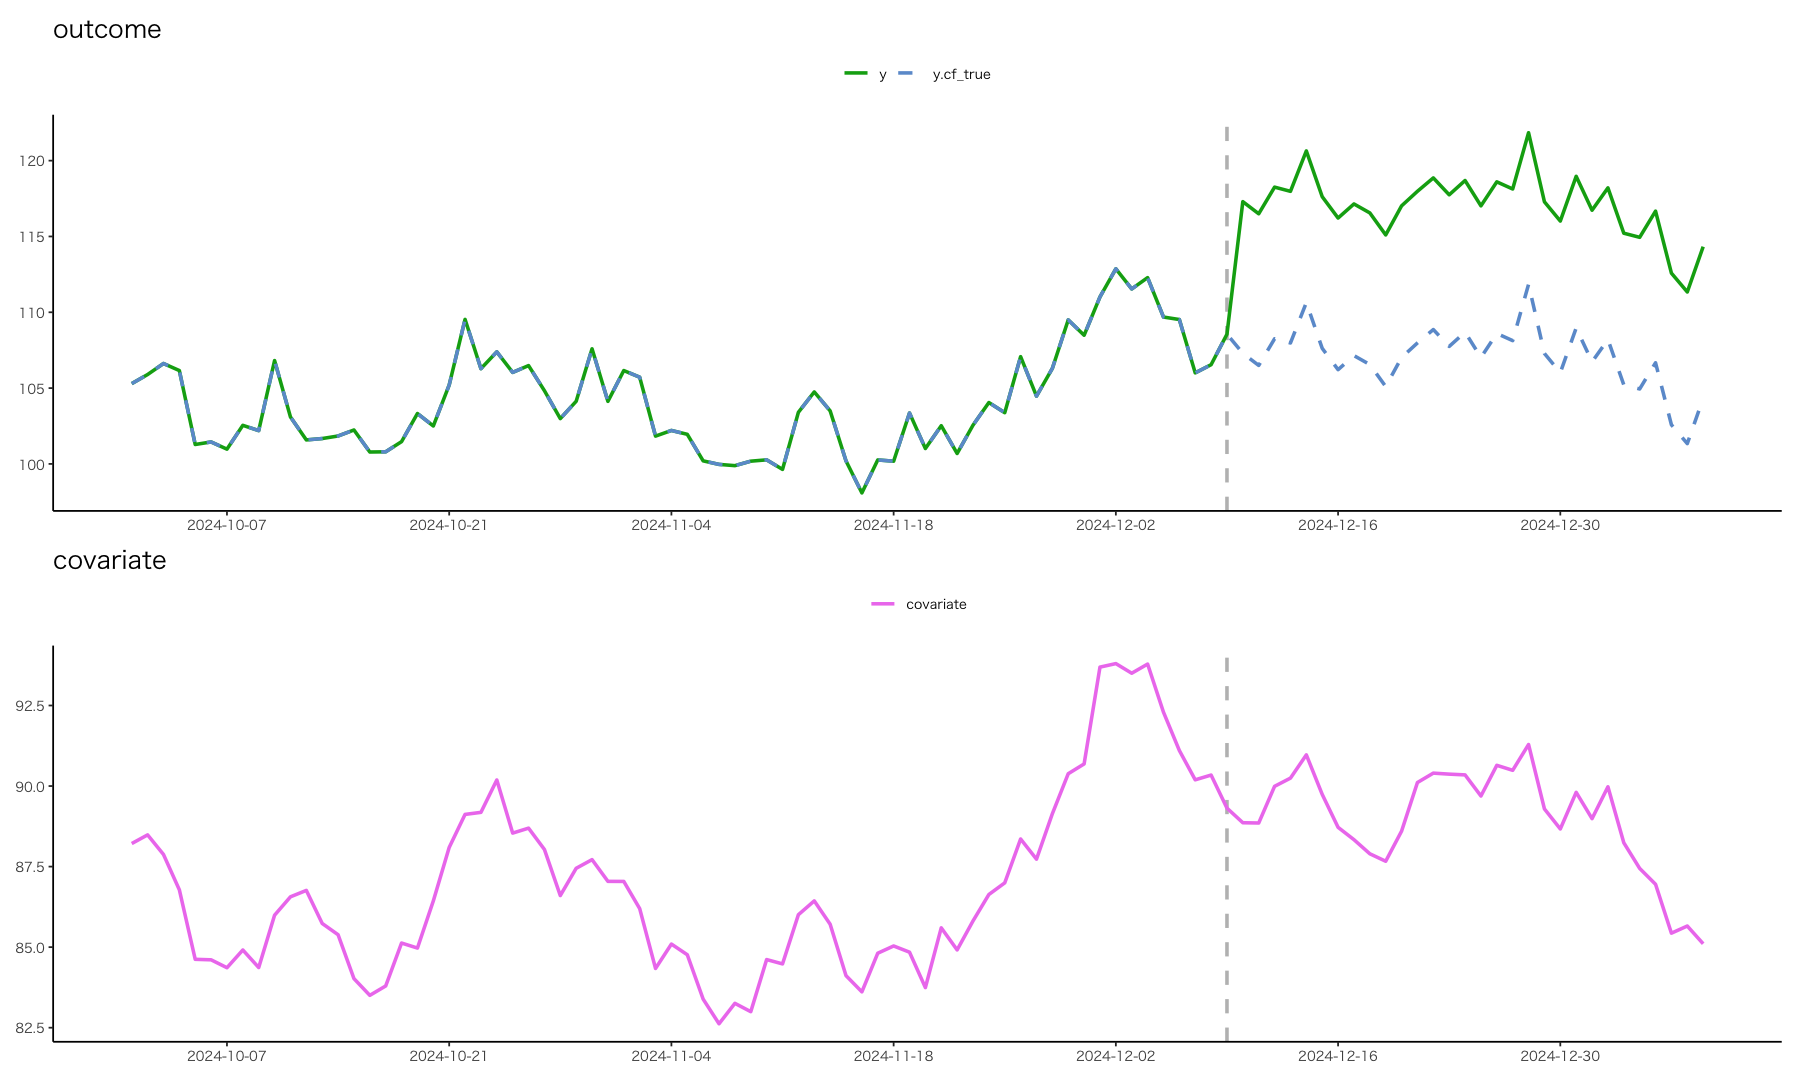

In [9]:
func_plot_check(df = data.tutorial)

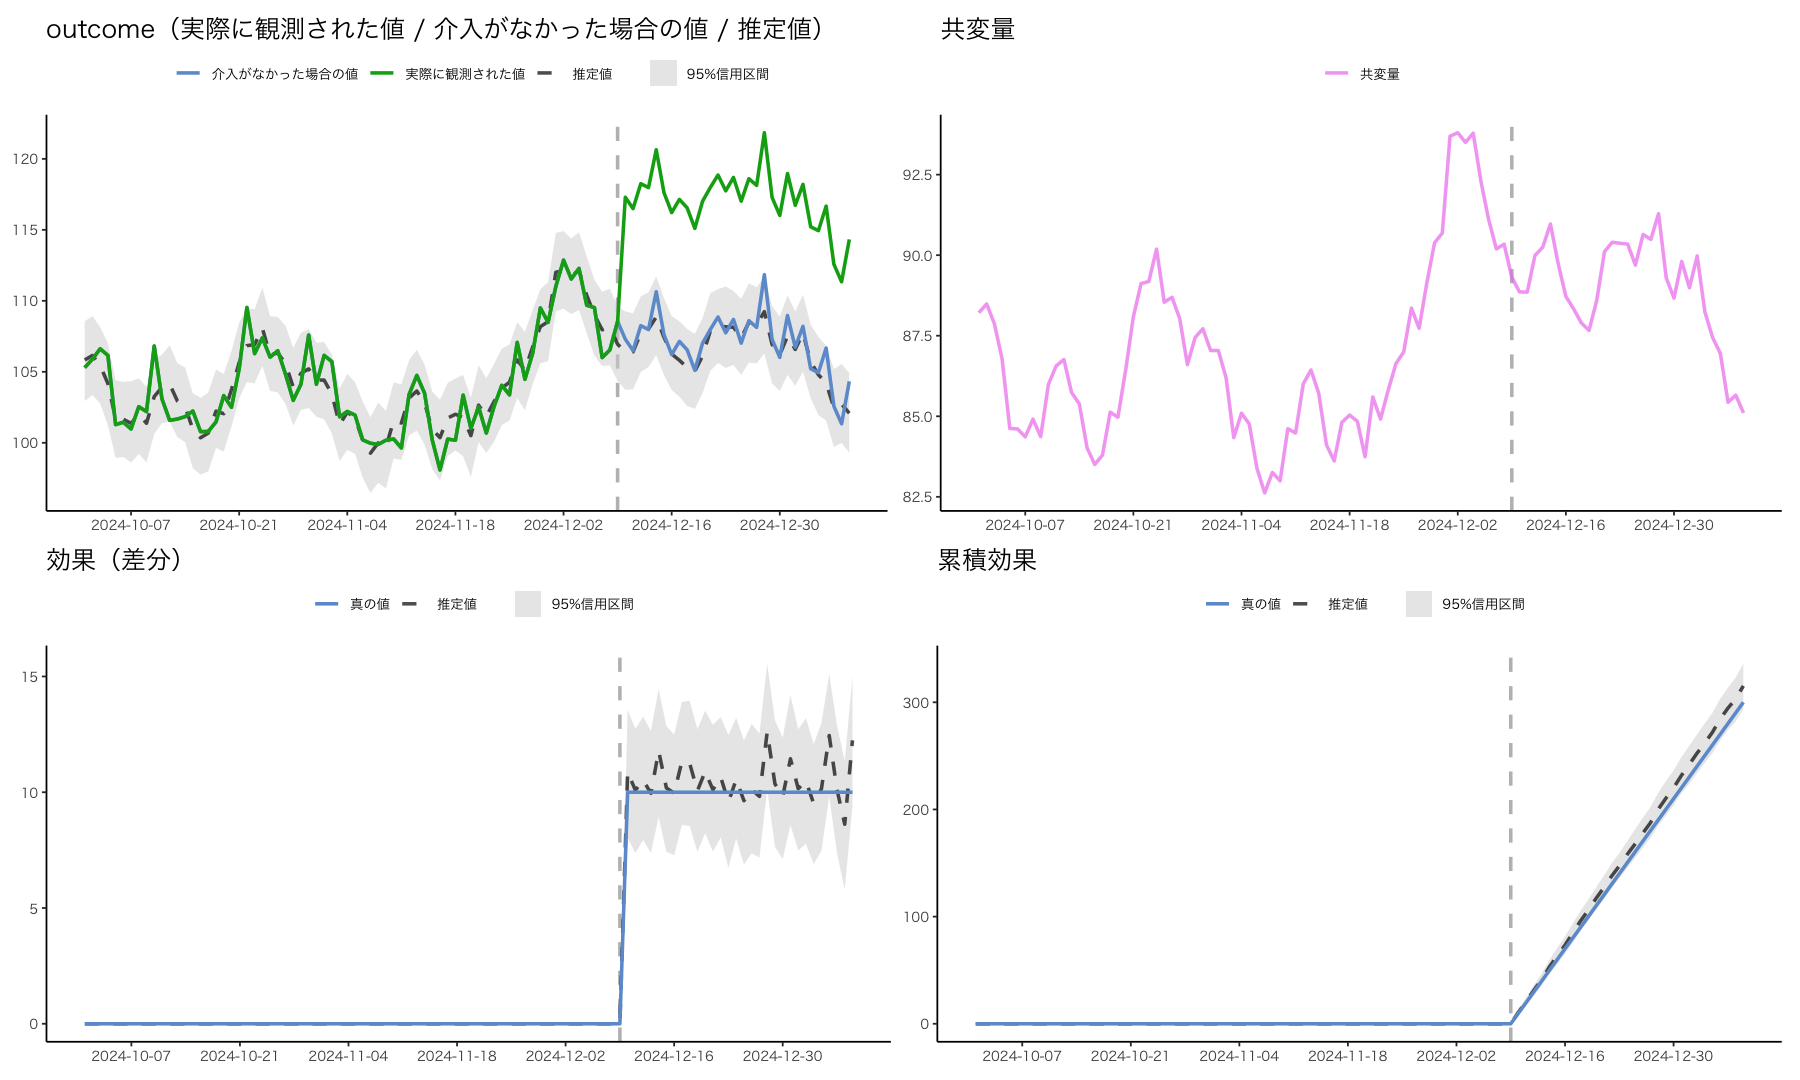

In [10]:
func_plot_CIresult_diff_trueEffect(data = data.tutorial
                                   , impact = impact.tutorial
                                   , pre_end_date = pre_end_date
                                  )

# アンチパターンを確認するうえで、基準となるデータを用意

In [11]:
# ベースとなるデータの作成
set.seed(1)

data.pattern_base <- data |>
  dplyr::mutate(y = if_else(date >= post_start_date, (y.cf_true + rnorm(n)) + 10, y.cf_true)) |>
  dplyr::select(date, y.cf_true, y, covariate)

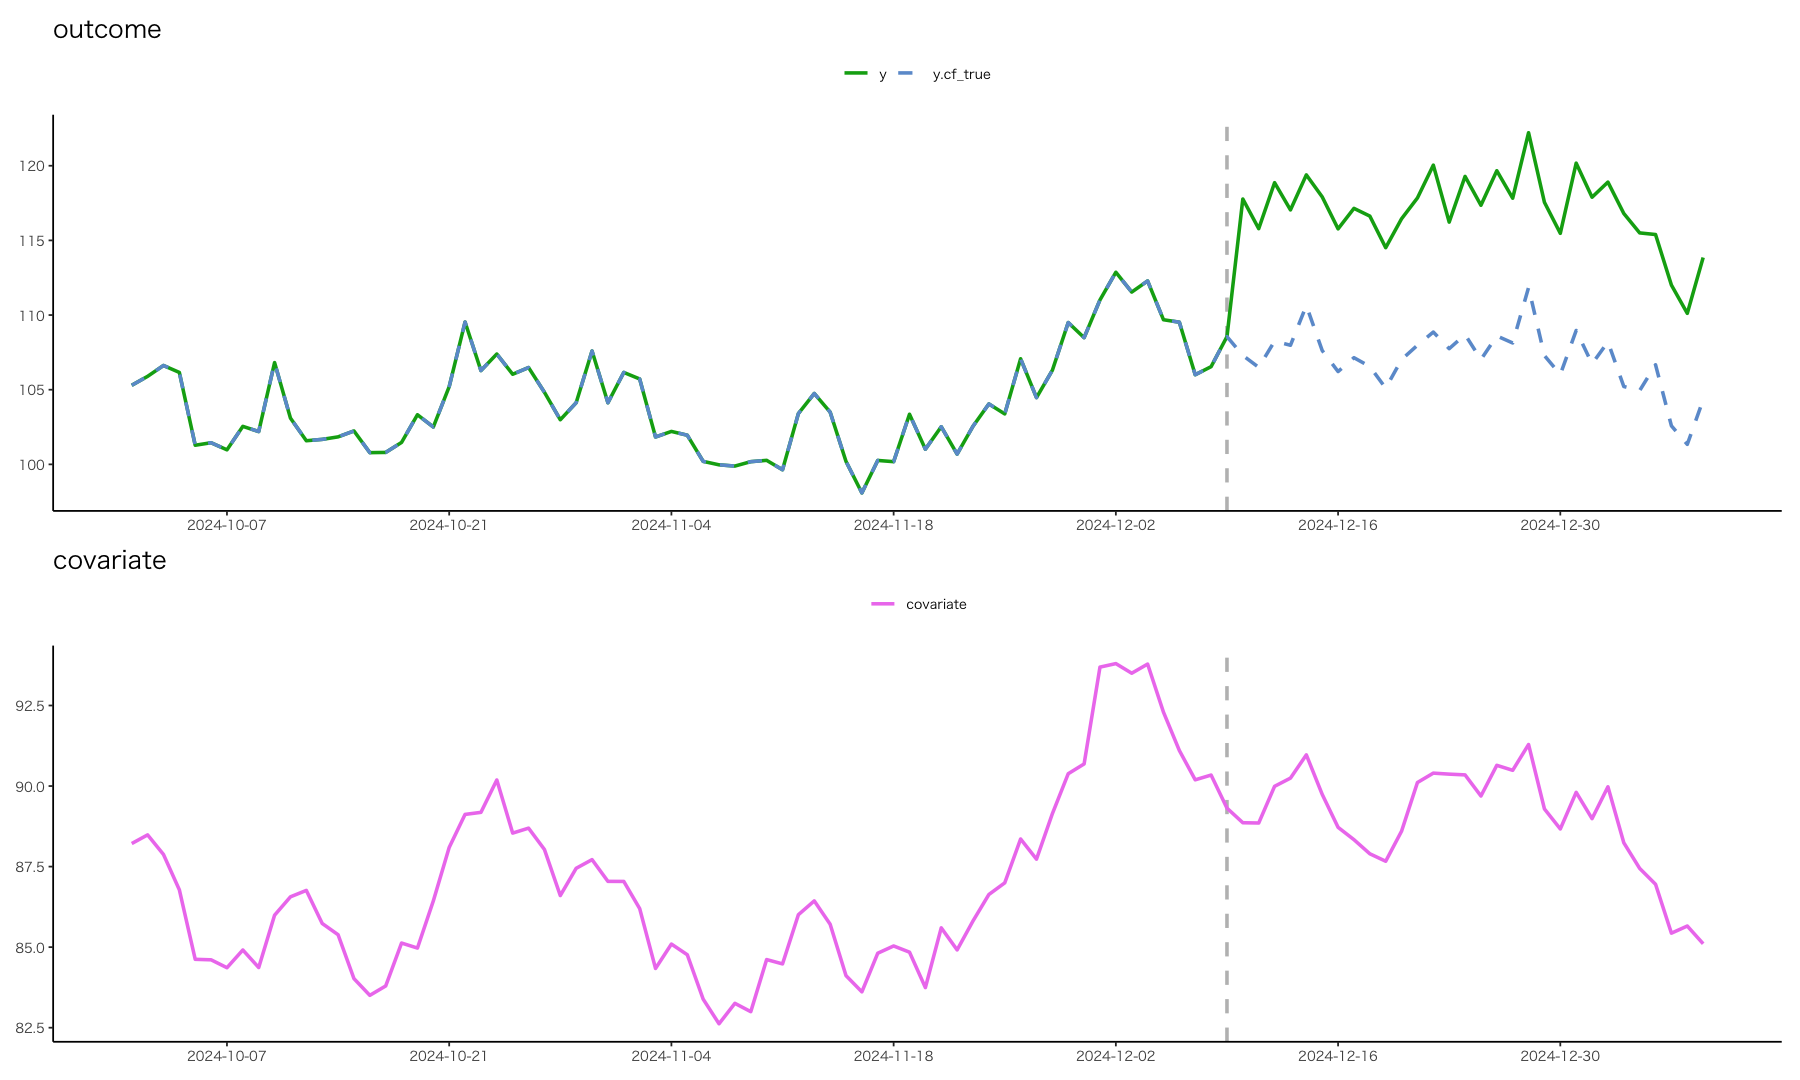

In [12]:
func_plot_check(df = data.pattern_base)

In [13]:
# CausalImpactの実行
set.seed(1)
impact.pattern_base <- CausalImpact::CausalImpact(data = data.pattern_base |> dplyr::select(date, y, covariate)
																							    , pre.period = pre.period
																						    	, post.period = post.period
																						     )

Posterior inference {CausalImpact}

                         Average        Cumulative  
Actual                   117            3511        
Prediction (s.d.)        107 (0.35)     3196 (10.48)
95% CI                   [106, 107]     [3175, 3218]
                                                    
Absolute effect (s.d.)   11 (0.35)      315 (10.48) 
95% CI                   [9.8, 11]      [293.5, 336]
                                                    
Relative effect (s.d.)   9.9% (0.36%)   9.9% (0.36%)
95% CI                   [9.1%, 11%]    [9.1%, 11%] 

Posterior tail-area probability p:   0.00101
Posterior prob. of a causal effect:  99.8993%

For more details, type: summary(impact, "report")



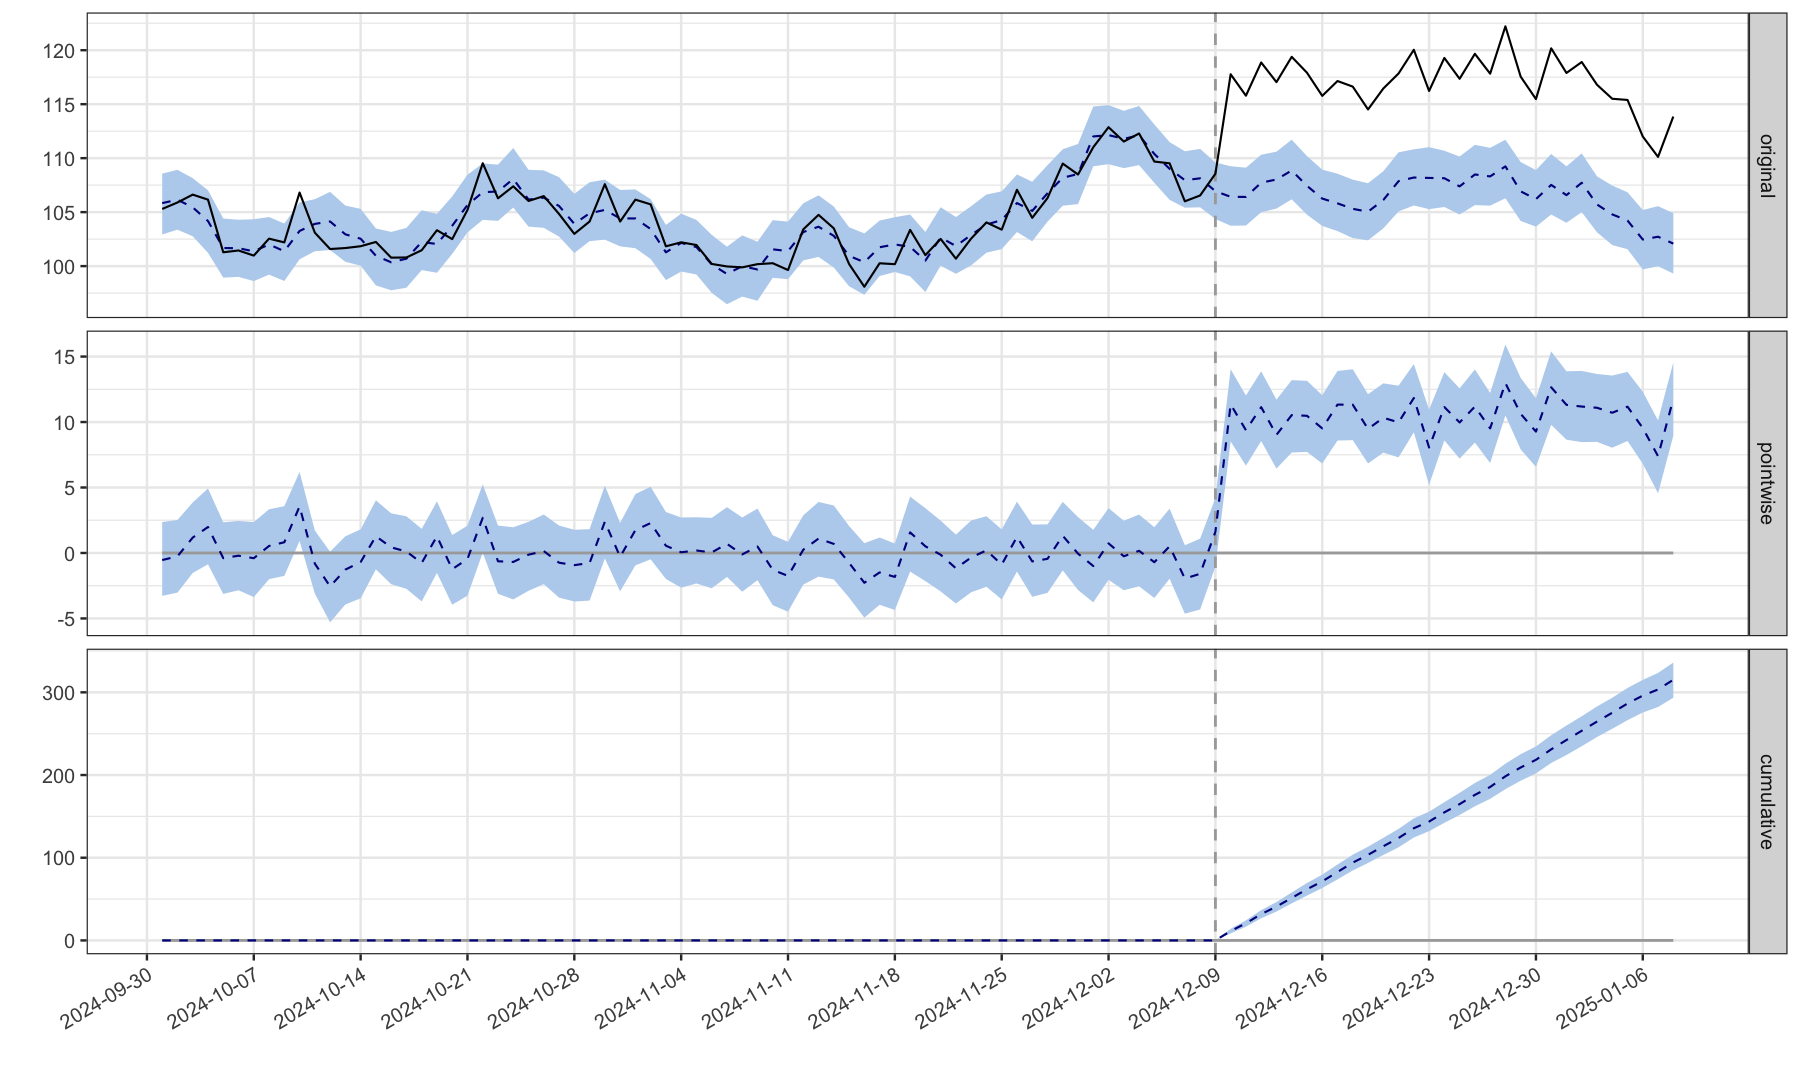

In [14]:
# CausalImpactの結果確認
summary(impact.pattern_base)
plot(impact.pattern_base) +
  scale_x_date(date_breaks = '1 week'
               , date_labels = '%Y-%m-%d'
               , minor_breaks = '1 week'
              ) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1))

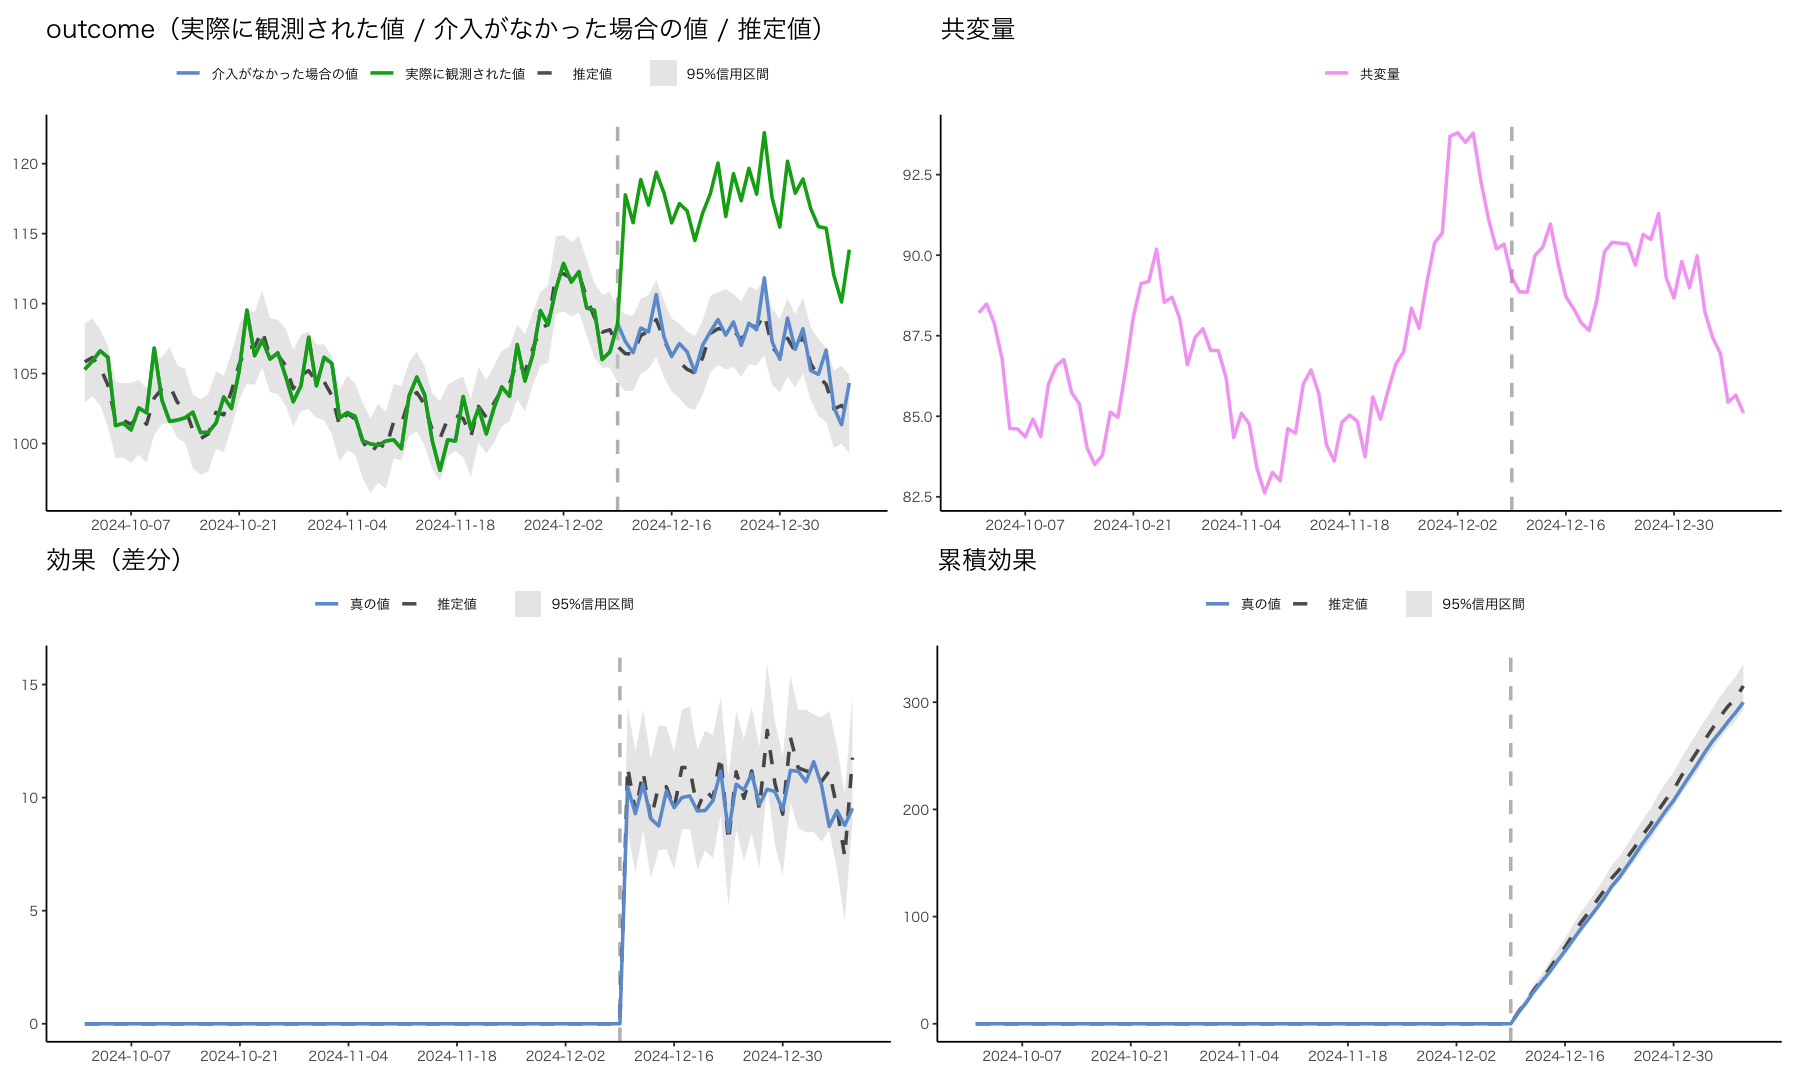

In [15]:
func_plot_CIresult_diff_trueEffect(data = data.pattern_base
                                   , impact = impact.pattern_base
                                   , pre_end_date = pre_end_date
                                  )

# アンチパターン

## アンチパターン 1：共変量シフト

### 1_1：プラス方向へのシフト

In [16]:
# 共変量シフトが起きているデータの作成
data.pattern1_1 <- data.pattern_base |>
  dplyr::mutate(covariate = if_else(date >= post_start_date, covariate + 5, covariate))

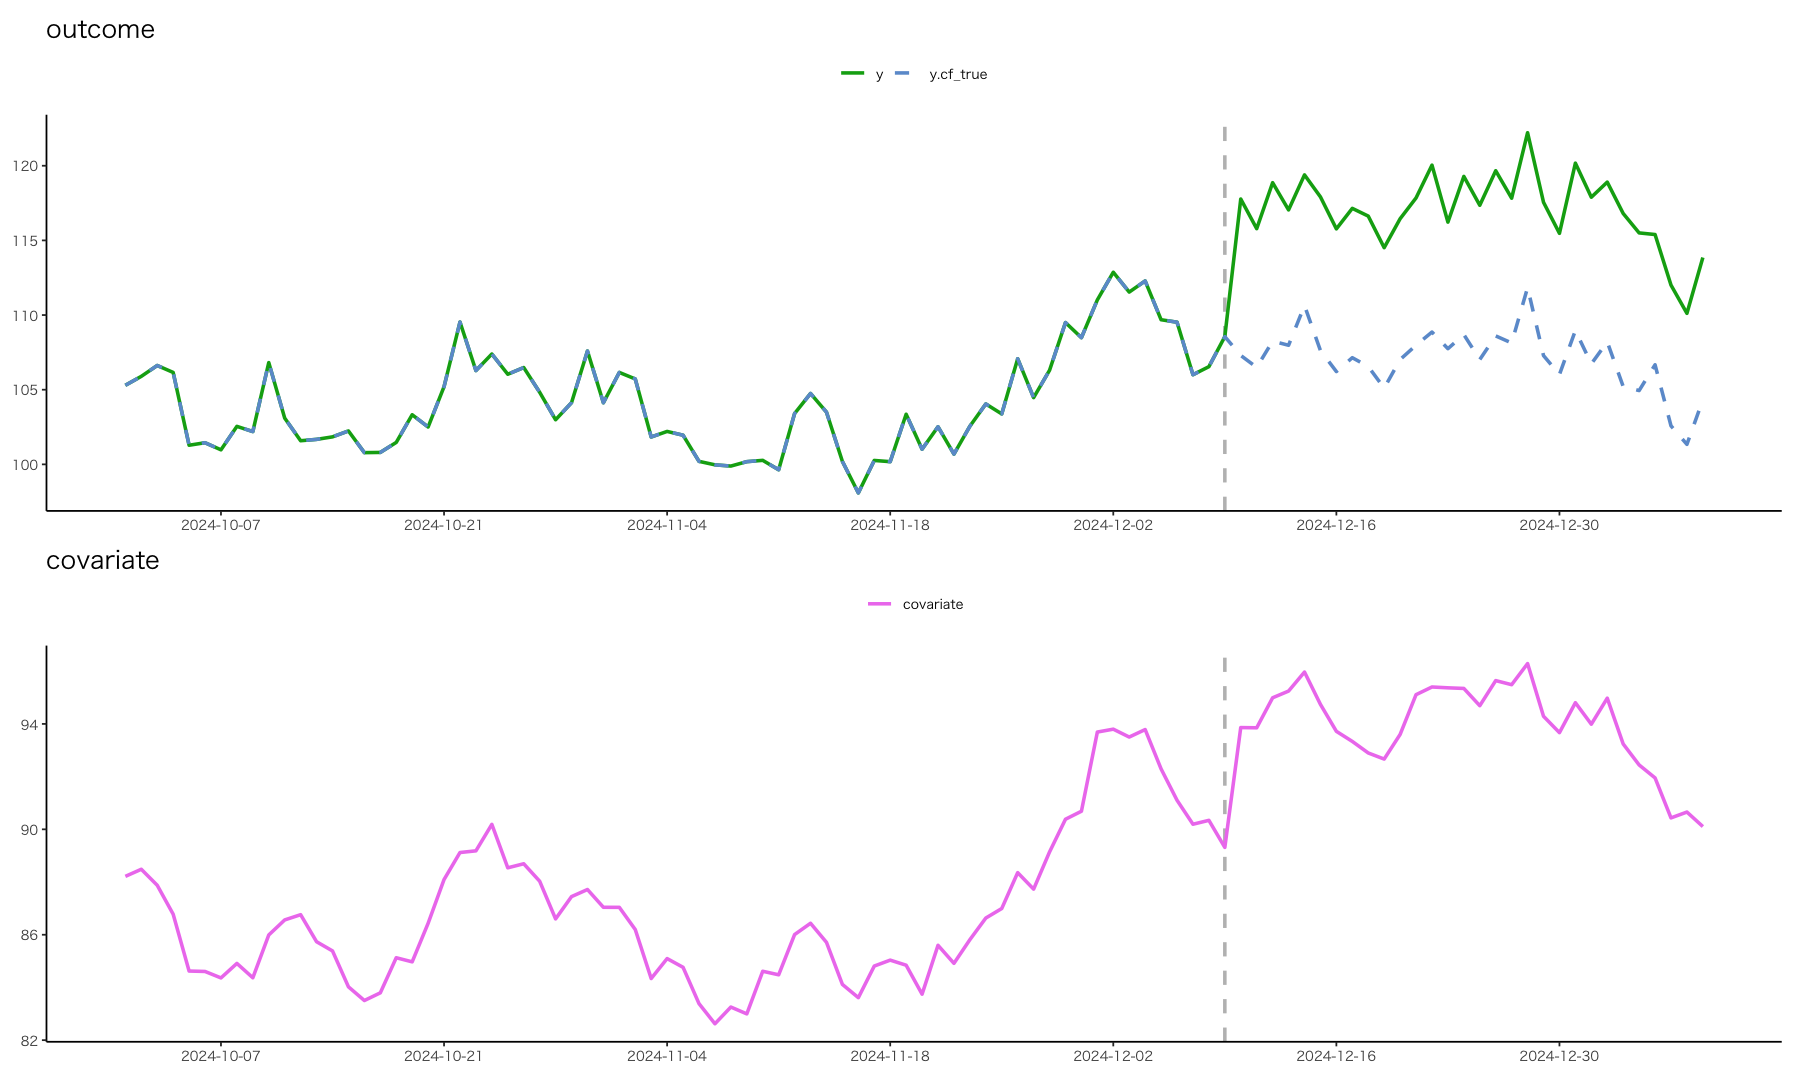

In [17]:
func_plot_check(df = data.pattern1_1)

In [18]:
# CausalImpactの実行
set.seed(1)
impact.pattern1_1 <- CausalImpact::CausalImpact(data = data.pattern1_1 |> dplyr::select(date, y, covariate)
																							  , pre.period = pre.period
																						    , post.period = post.period
																						   )

Posterior inference {CausalImpact}

                         Average        Cumulative    
Actual                   117            3511          
Prediction (s.d.)        112 (0.53)     3370 (15.81)  
95% CI                   [111, 113]     [3337, 3402]  
                                                      
Absolute effect (s.d.)   4.7 (0.53)     141.6 (15.81) 
95% CI                   [3.7, 5.8]     [109.6, 174.1]
                                                      
Relative effect (s.d.)   4.2% (0.49%)   4.2% (0.49%)  
95% CI                   [3.2%, 5.2%]   [3.2%, 5.2%]  

Posterior tail-area probability p:   0.00101
Posterior prob. of a causal effect:  99.8993%

For more details, type: summary(impact, "report")



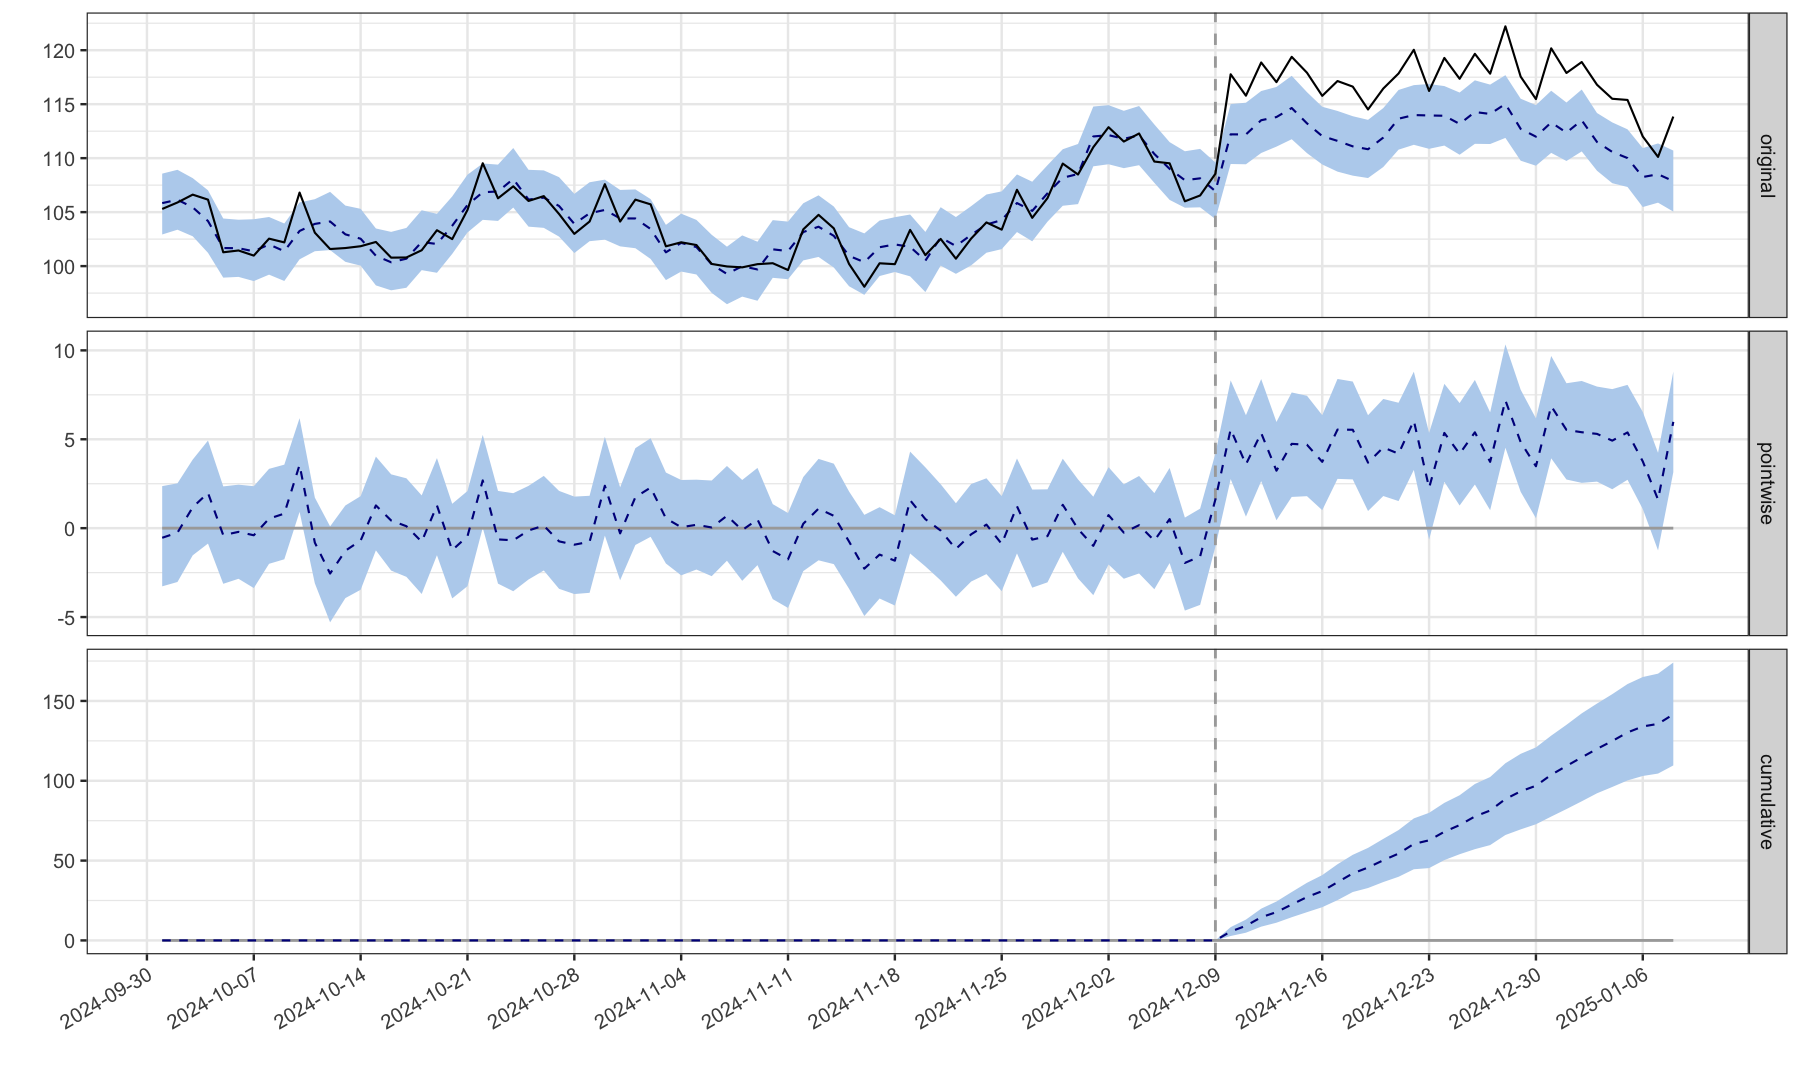

In [19]:
# CausalImpactの結果確認
summary(impact.pattern1_1)
plot(impact.pattern1_1) +
  scale_x_date(date_breaks = '1 week'
               , date_labels = '%Y-%m-%d'
               , minor_breaks = '1 week'
              ) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1))

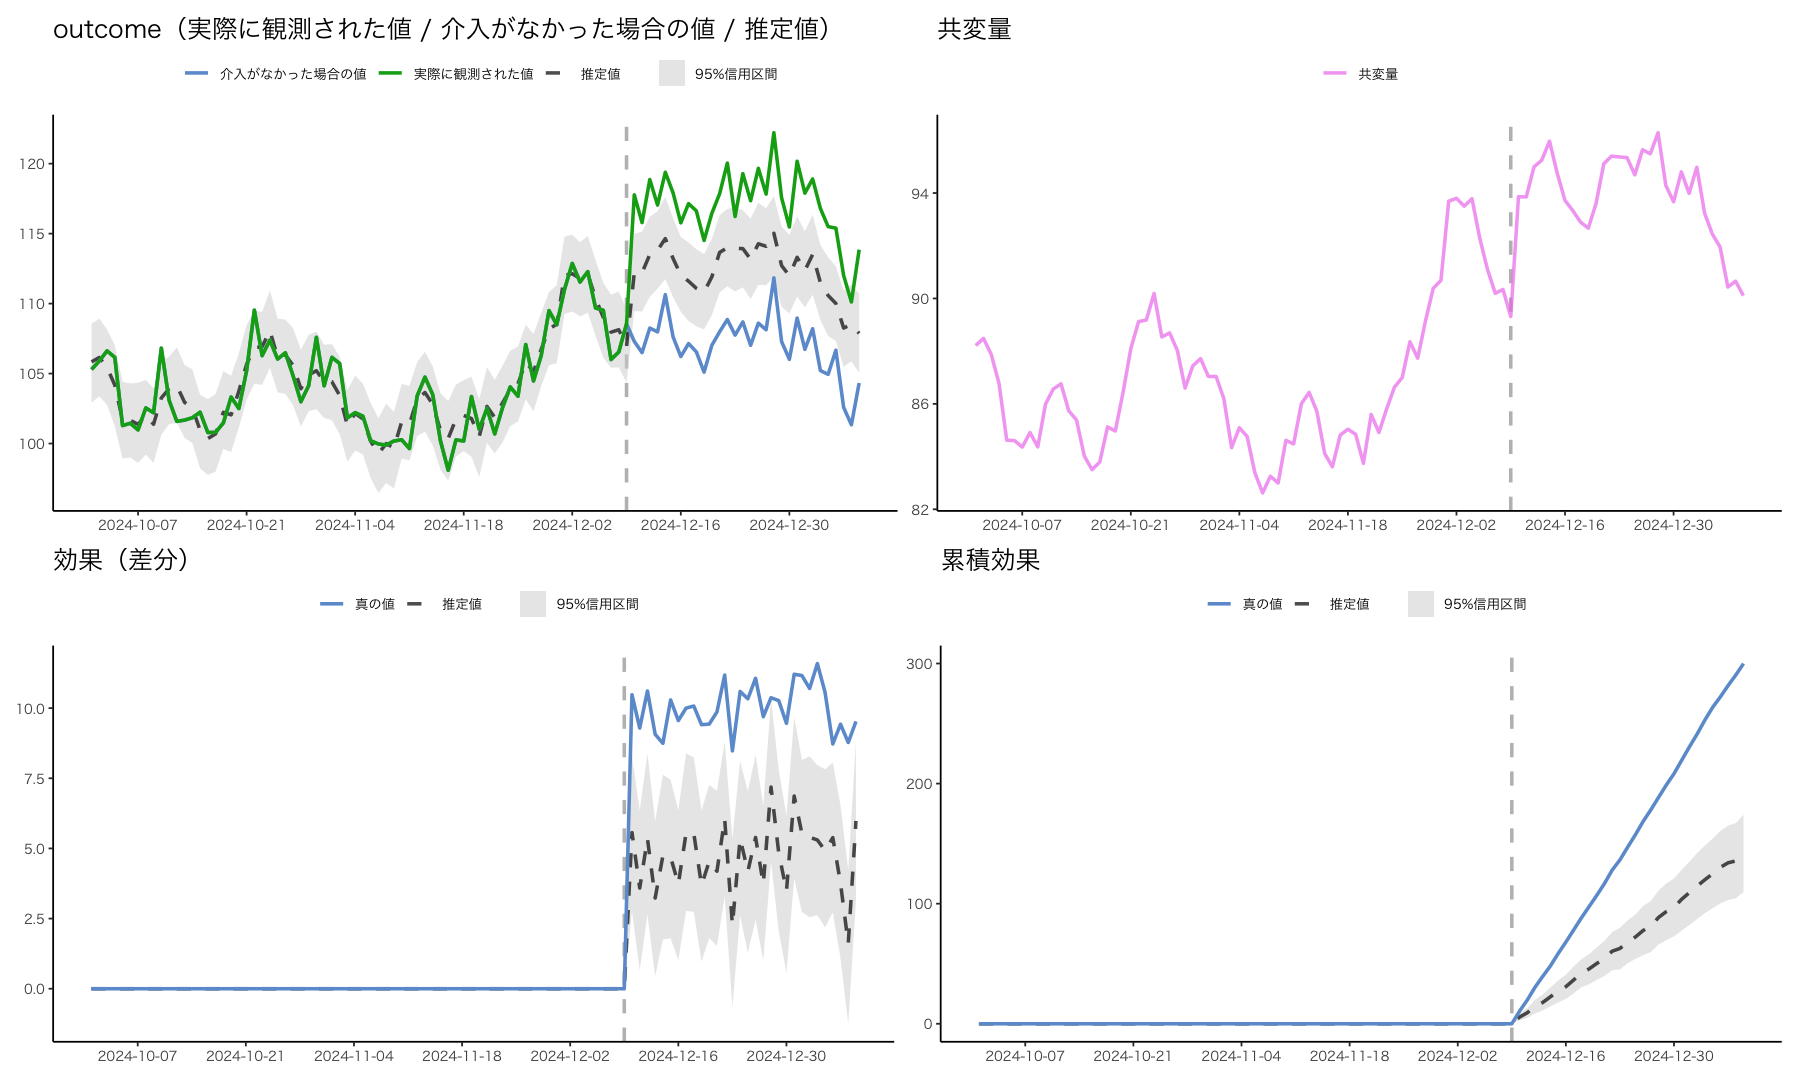

In [20]:
func_plot_CIresult_diff_trueEffect(data = data.pattern1_1
                                   , impact = impact.pattern1_1
                                   , pre_end_date = pre_end_date
                                  )

### 1_2：マイナス方向へのシフト

In [21]:
# 共変量シフトが起きているデータの作成
data.pattern1_2 <- data.pattern_base |>
  dplyr::mutate(covariate = if_else(date >= post_start_date, covariate - 2, covariate))

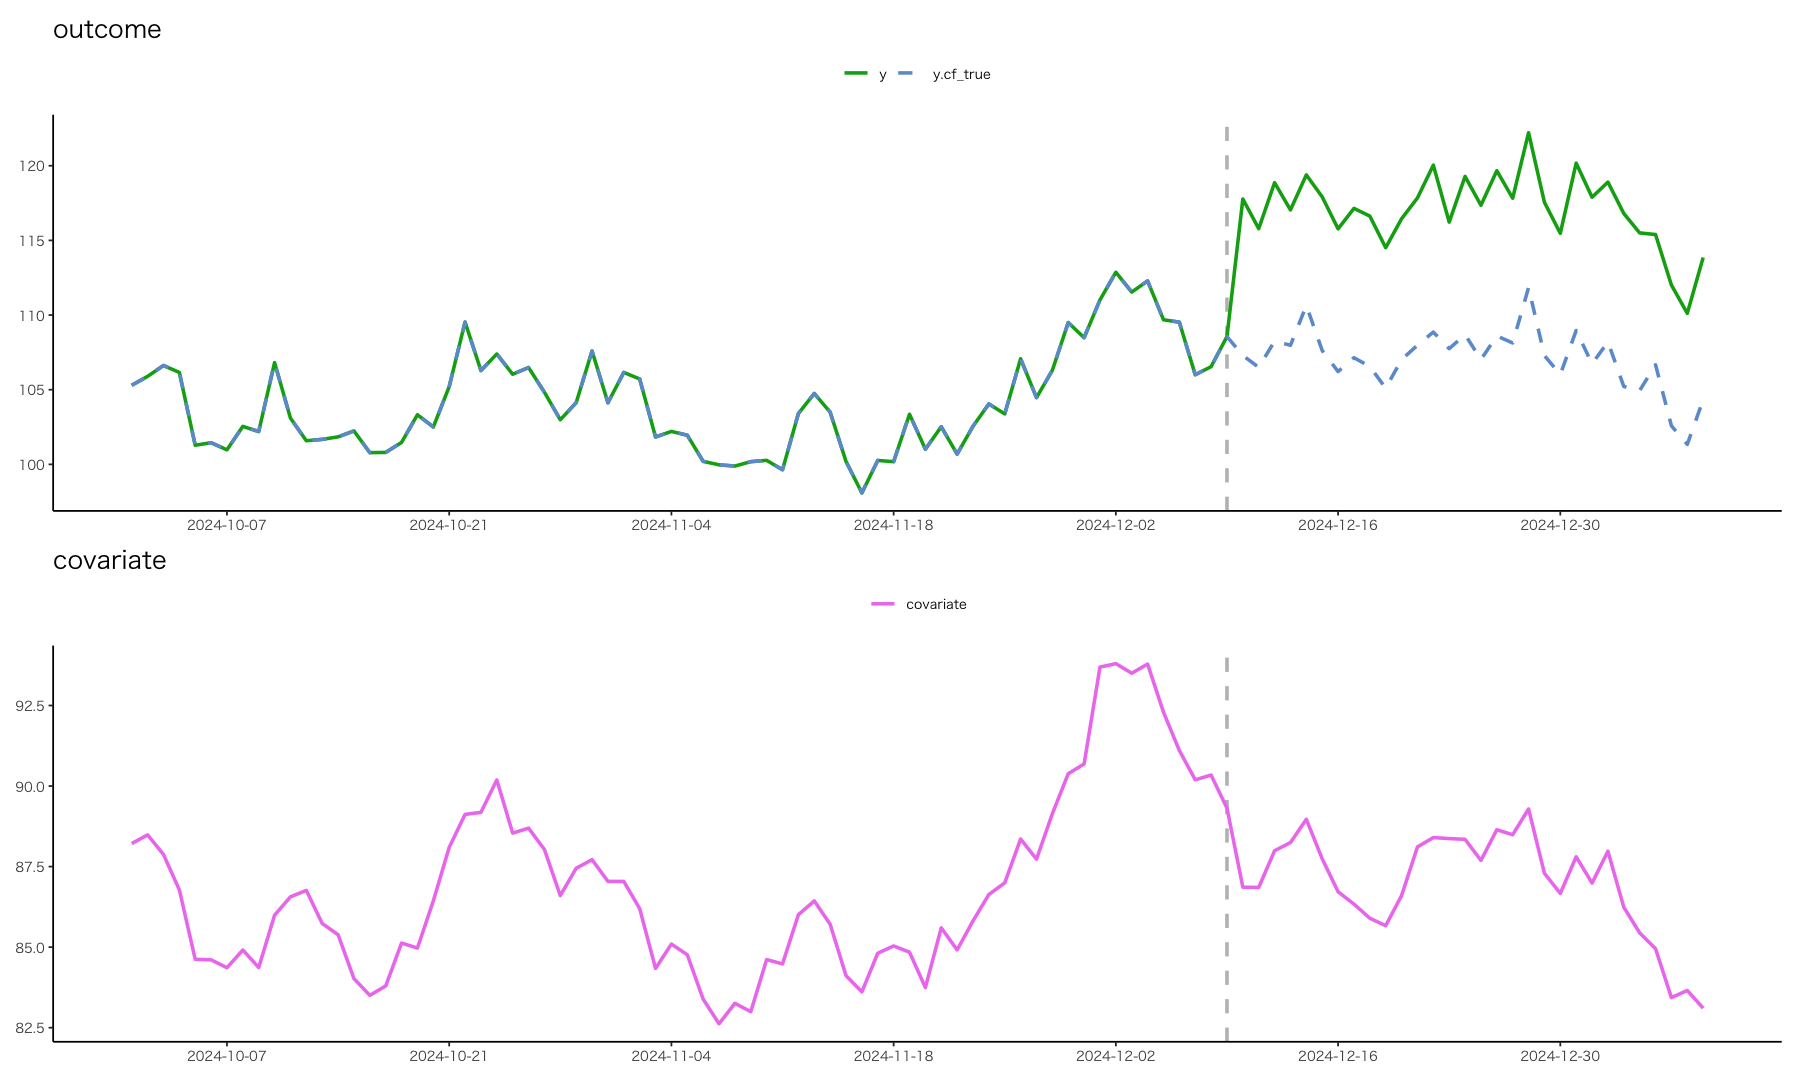

In [22]:
func_plot_check(df = data.pattern1_2)

In [23]:
# CausalImpactの実行
set.seed(1)
impact.pattern1_2 <- CausalImpact::CausalImpact(data = data.pattern1_2 |> dplyr::select(date, y, covariate)
																							  , pre.period = pre.period
																						    , post.period = post.period
																						   )

Posterior inference {CausalImpact}

                         Average       Cumulative  
Actual                   117           3511        
Prediction (s.d.)        104 (0.33)    3127 (9.96) 
95% CI                   [104, 105]    [3107, 3146]
                                                   
Absolute effect (s.d.)   13 (0.33)     385 (9.96)  
95% CI                   [12, 13]      [366, 404]  
                                                   
Relative effect (s.d.)   12% (0.36%)   12% (0.36%) 
95% CI                   [12%, 13%]    [12%, 13%]  

Posterior tail-area probability p:   0.00101
Posterior prob. of a causal effect:  99.8993%

For more details, type: summary(impact, "report")



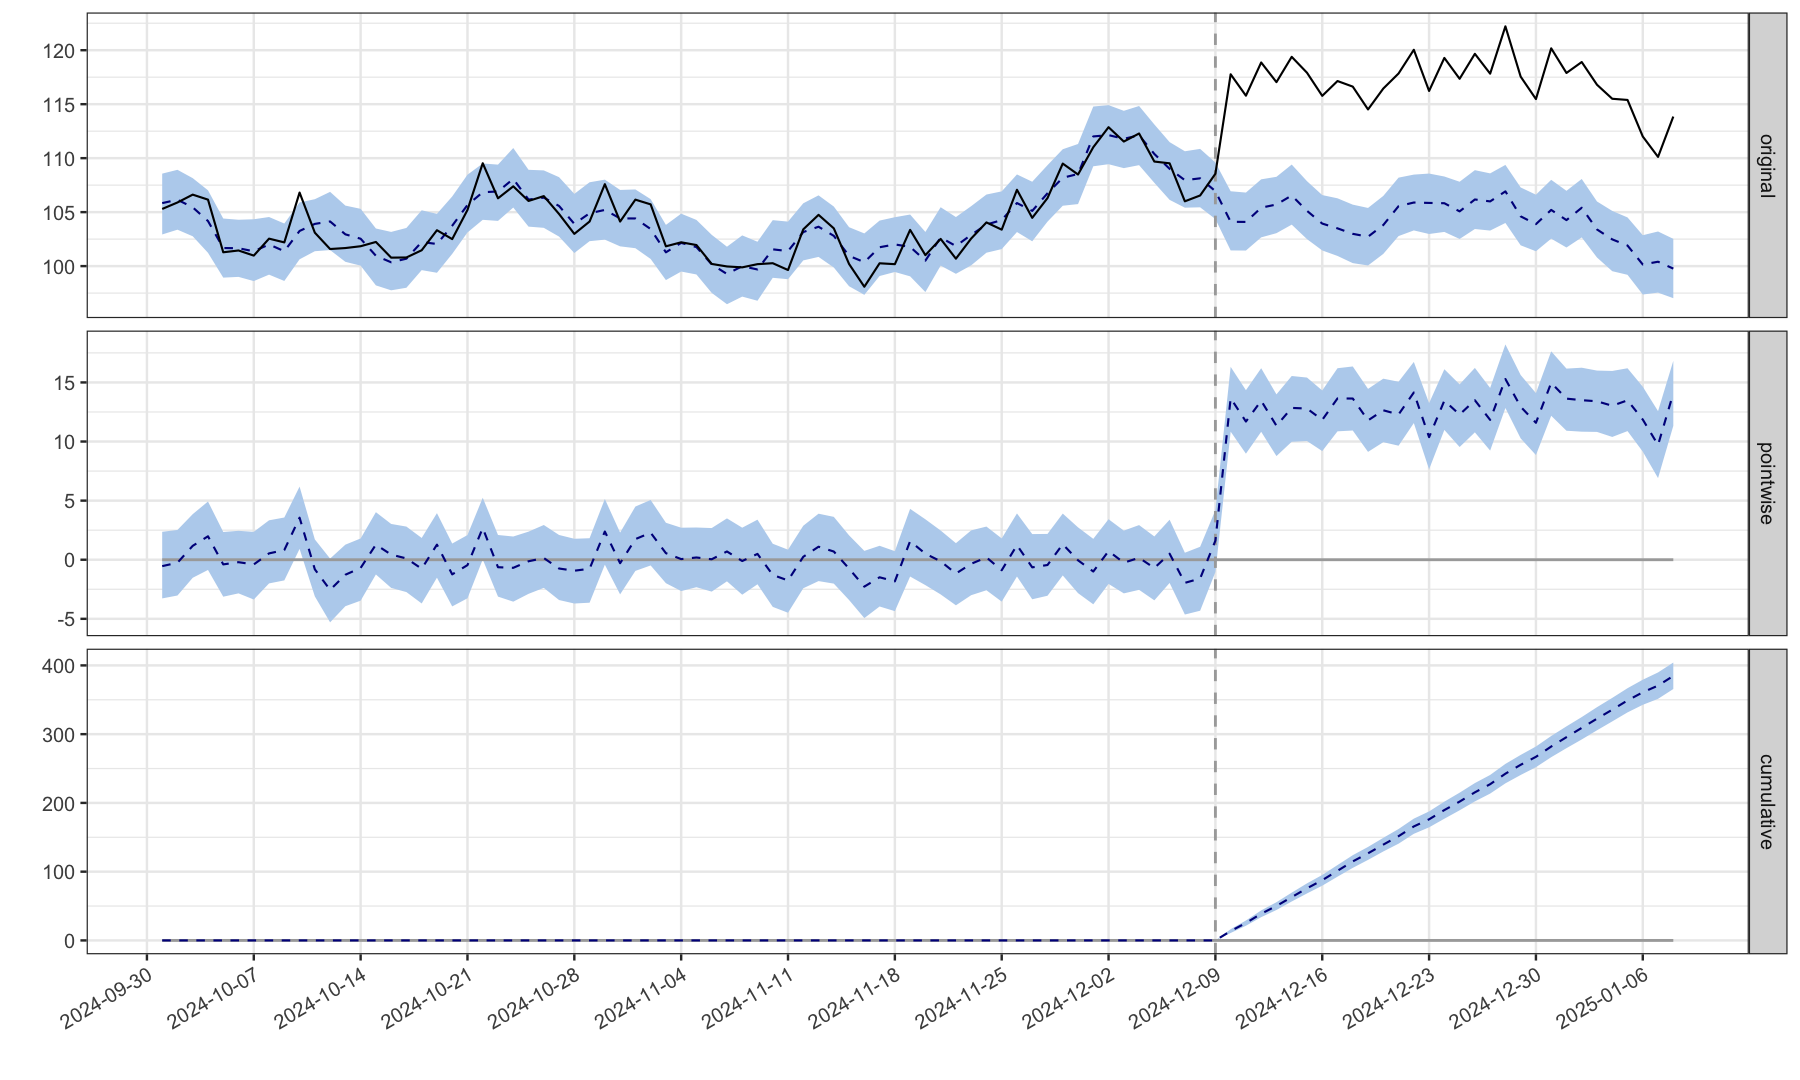

In [24]:
# CausalImpactの結果確認
summary(impact.pattern1_2)
plot(impact.pattern1_2) +
  scale_x_date(date_breaks = '1 week'
               , date_labels = '%Y-%m-%d'
               , minor_breaks = '1 week'
              ) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1))

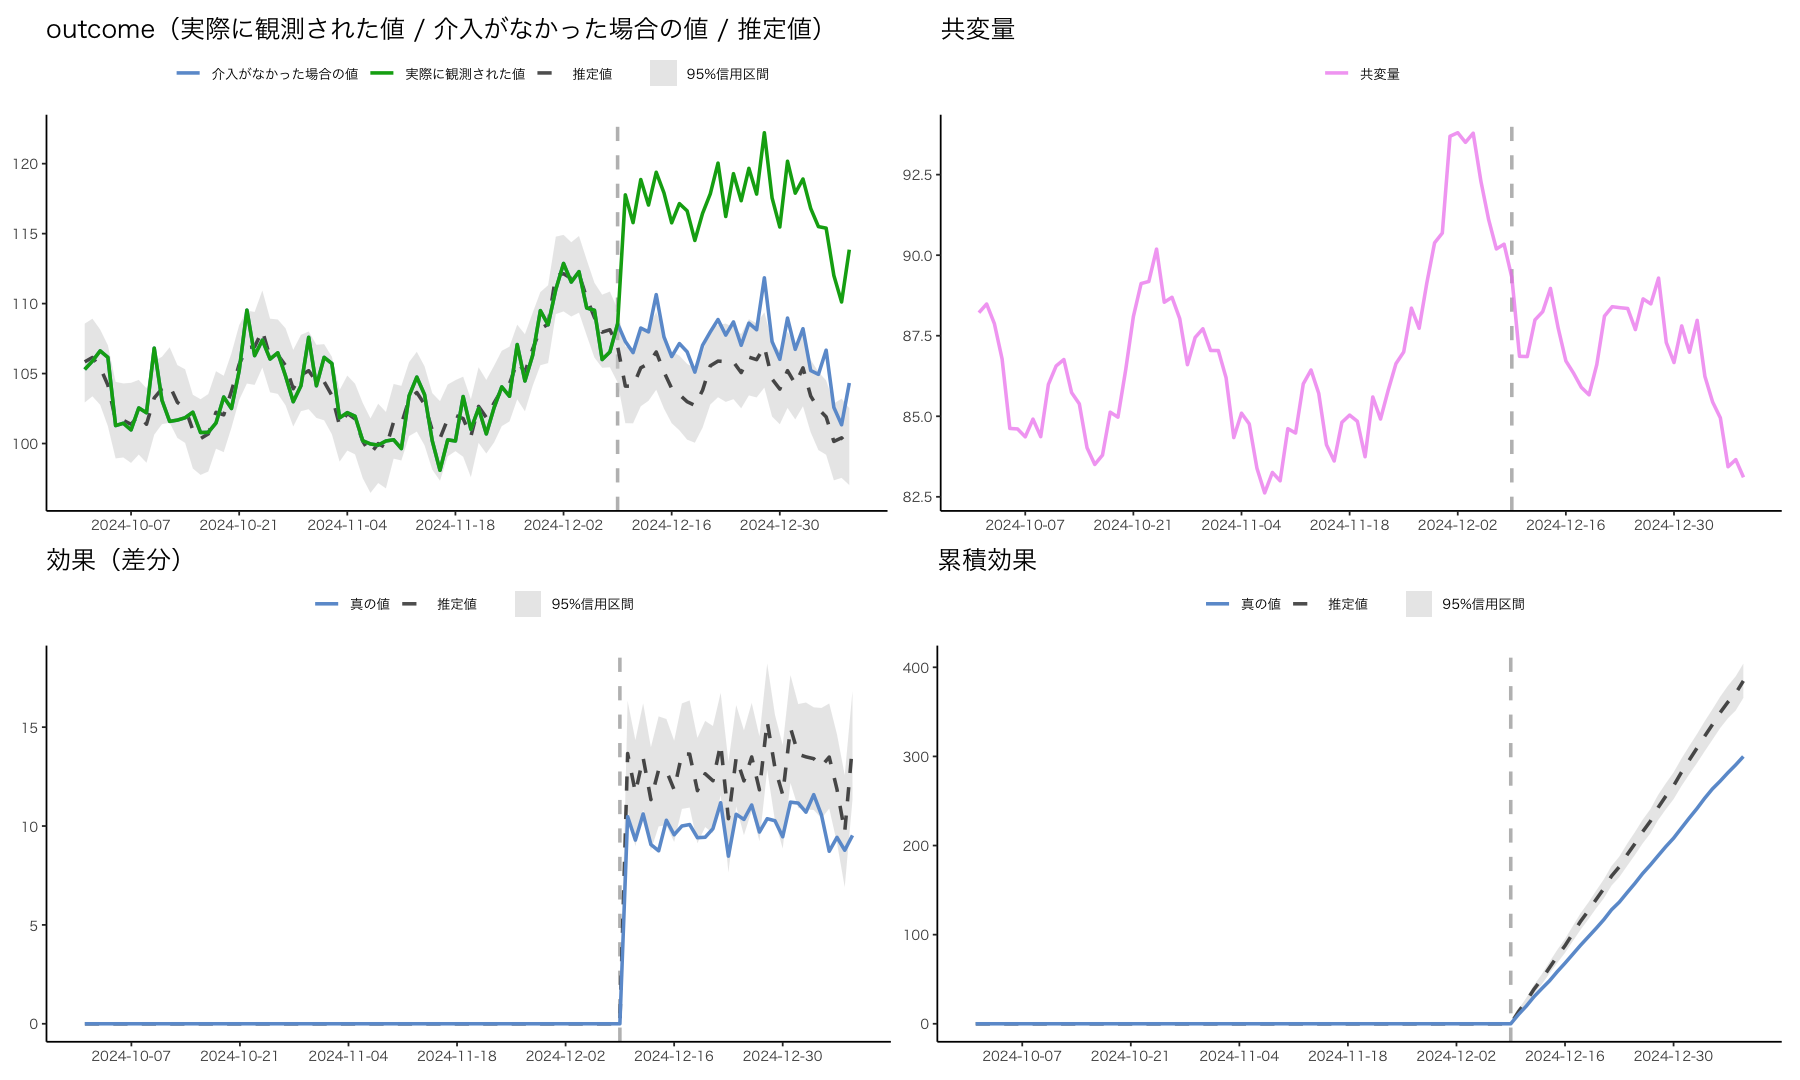

In [25]:
func_plot_CIresult_diff_trueEffect(data = data.pattern1_2
                                   , impact = impact.pattern1_2
                                   , pre_end_date = pre_end_date
                                  )

## アンチパターン 2：非線形性（獲得できる数が飽和する）

In [26]:
# 観測方程式が非線形（獲得できる数が飽和する）のデータの作成
set.seed(1)
data.pattern2 <- data.pattern_base |>
  dplyr::mutate(y = if_else(date >= post_start_date, (y.cf_true + rnorm(30, sd = 1.5) + 10 + log(1:30) * 0.5), y.cf_true)
	              , y.cf_true = if_else(date >= post_start_date, (y.cf_true + rnorm(30, sd = 1.0) + log(1:30)), y.cf_true)
							 ) |>
	dplyr::select(date, y.cf_true, y, covariate)

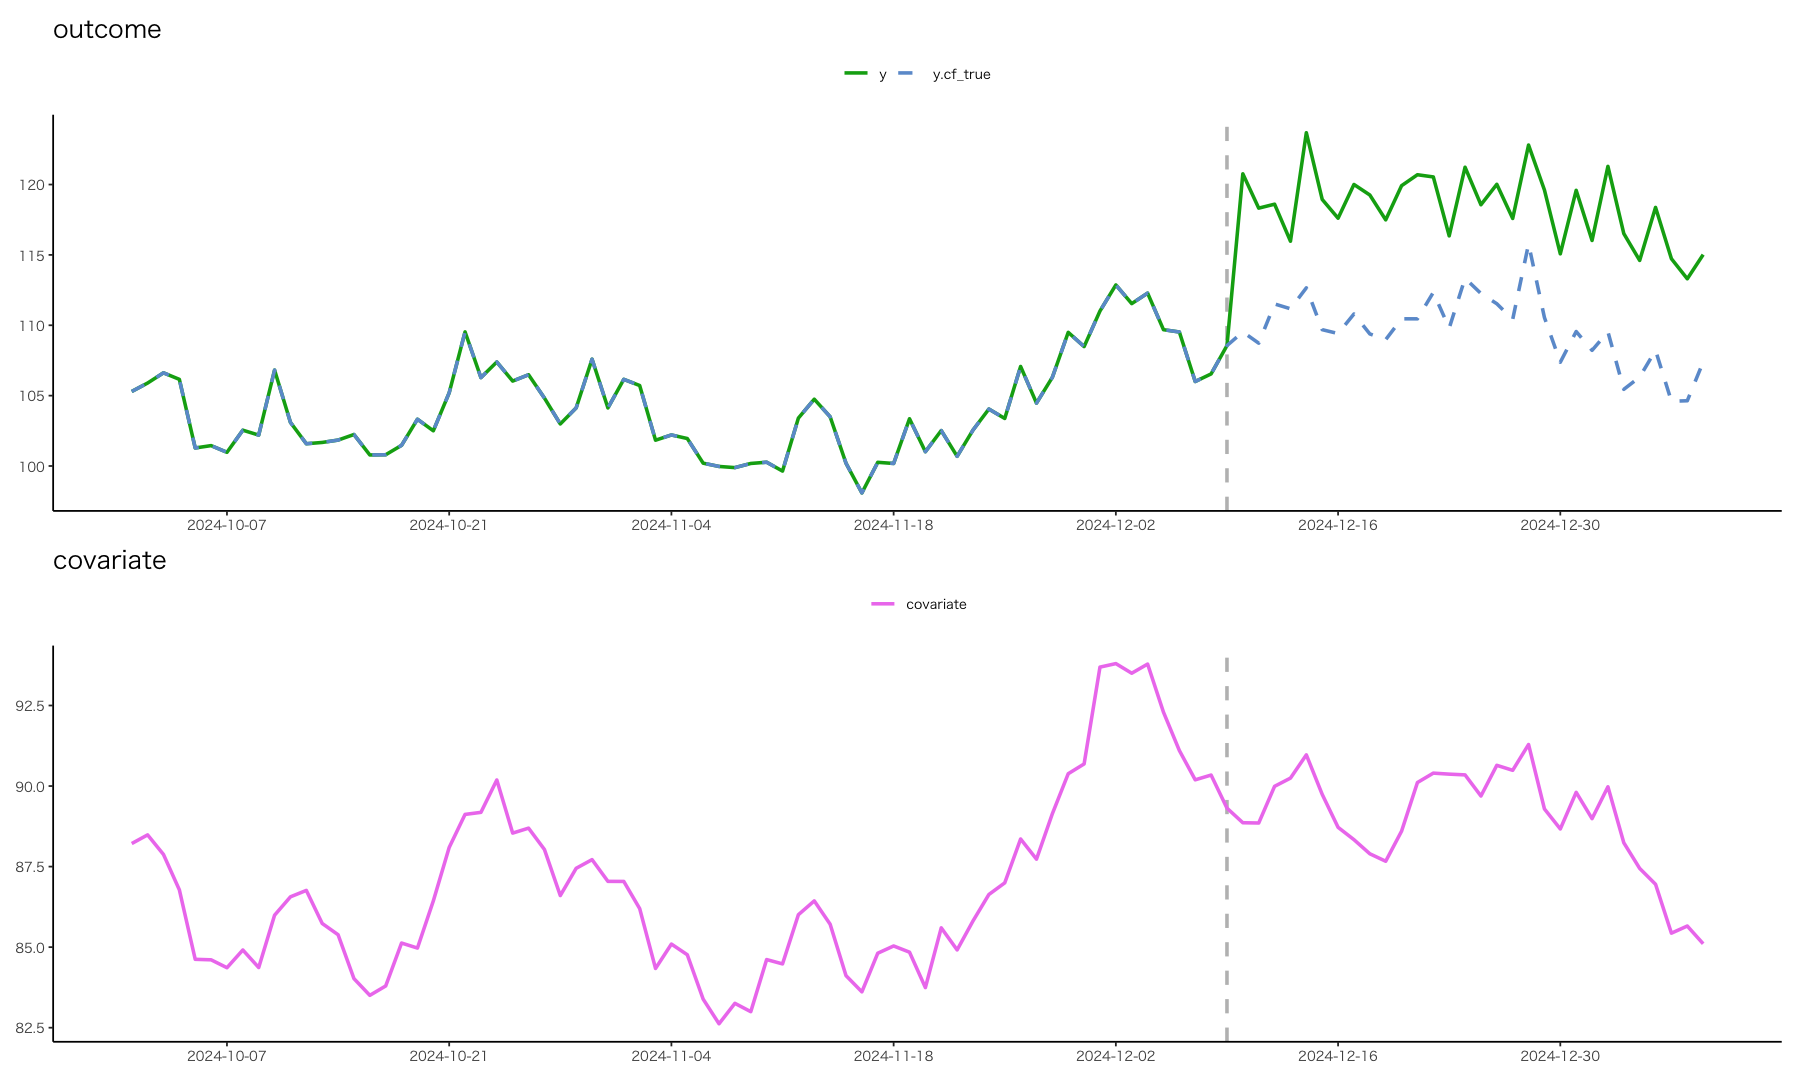

In [27]:
func_plot_check(df = data.pattern2)

In [28]:
# CausalImpactの実行
set.seed(1)
impact.pattern2 <- CausalImpact::CausalImpact(data = data.pattern2 |> dplyr::select(date, y, covariate)
																							, pre.period = pre.period
																						  , post.period = post.period
																						 )

Posterior inference {CausalImpact}

                         Average       Cumulative  
Actual                   118           3552        
Prediction (s.d.)        107 (0.35)    3196 (10.48)
95% CI                   [106, 107]    [3175, 3218]
                                                   
Absolute effect (s.d.)   12 (0.35)     356 (10.48) 
95% CI                   [11, 13]      [335, 377]  
                                                   
Relative effect (s.d.)   11% (0.36%)   11% (0.36%) 
95% CI                   [10%, 12%]    [10%, 12%]  

Posterior tail-area probability p:   0.00101
Posterior prob. of a causal effect:  99.8993%

For more details, type: summary(impact, "report")



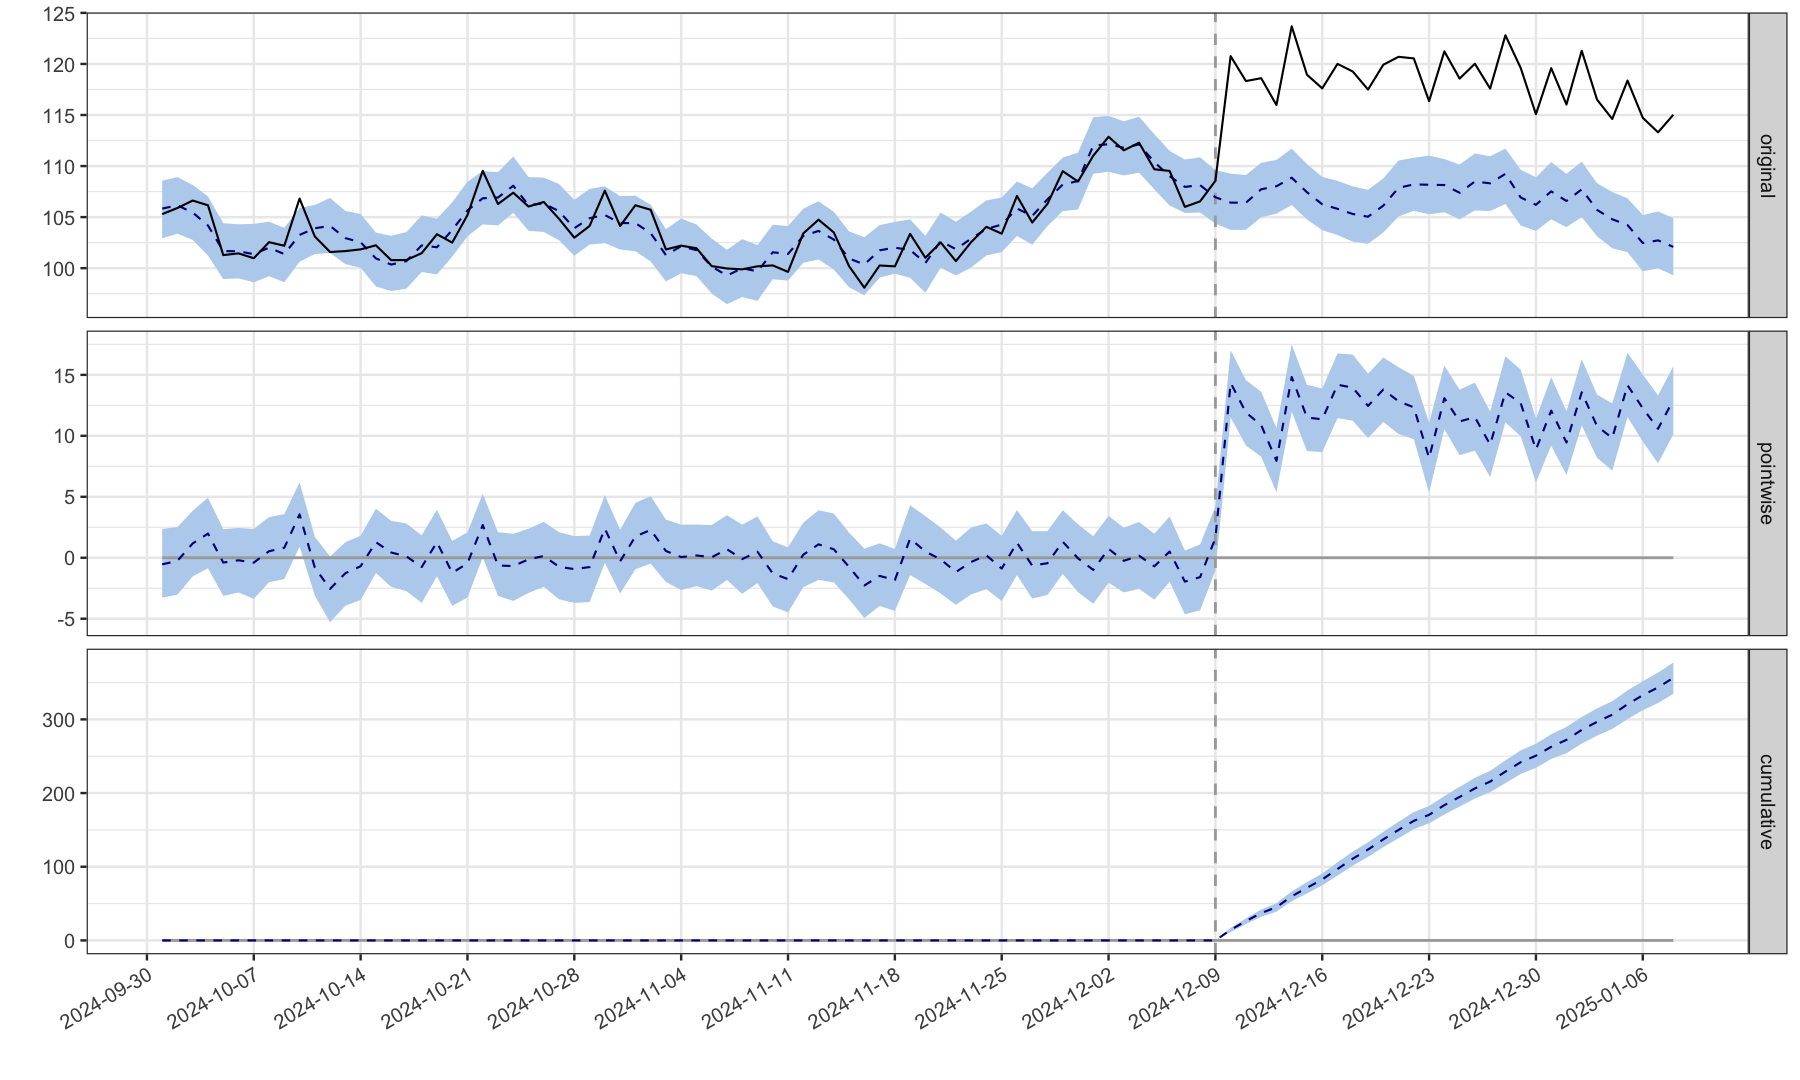

In [29]:
# CausalImpactの結果確認
summary(impact.pattern2)
plot(impact.pattern2) +
  scale_x_date(date_breaks = '1 week'
               , date_labels = '%Y-%m-%d'
               , minor_breaks = '1 week'
              ) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1))

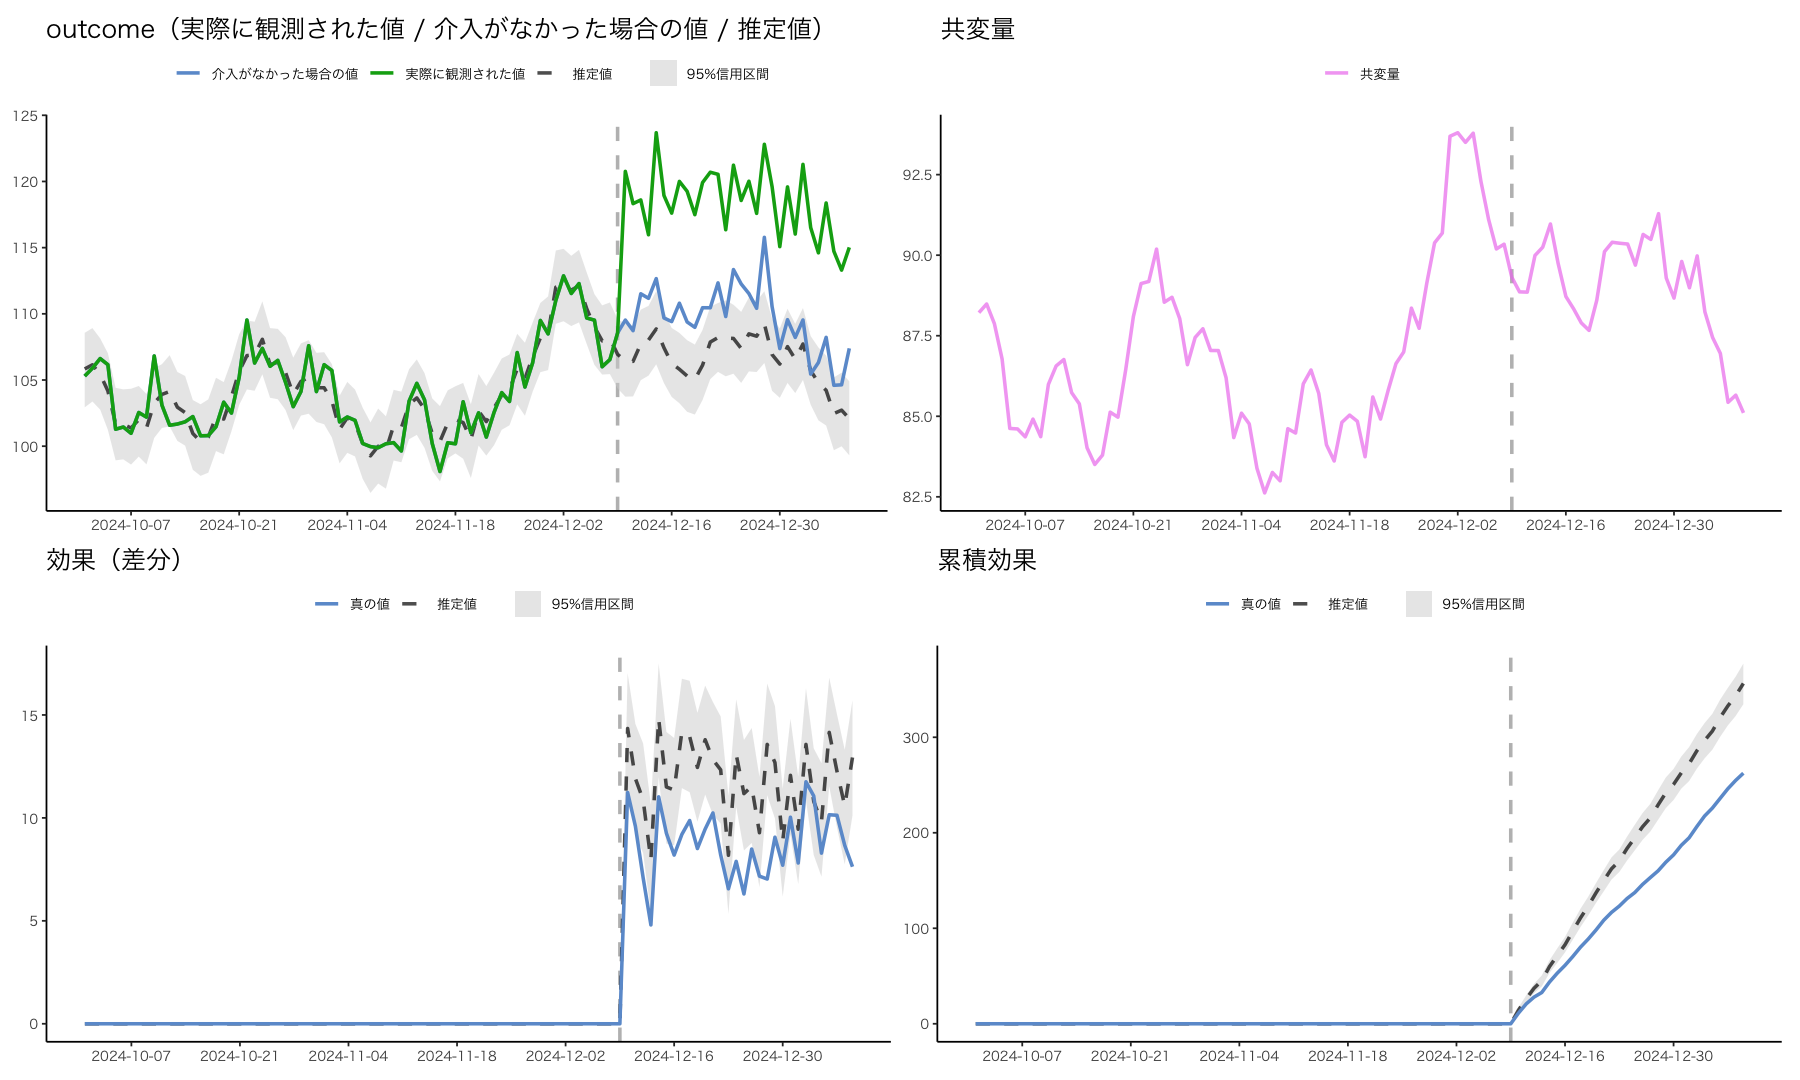

In [30]:
func_plot_CIresult_diff_trueEffect(data = data.pattern2
                                   , impact = impact.pattern2
                                   , pre_end_date = pre_end_date
                                  )

## アンチパターン 3：未観測の外部要因（周期性やトレンドの考慮漏れ）

In [31]:
# 季節性やトレンドを追加したデータフレームの生成
set.seed(1)
weekly_seasonal_effect <- 7 * sin(2 * pi * seq(1, n) / 7)  ## 週次の周期性
trend_effect <- seq(1, n) * 0.1

data.pattern3_1 <- data.pattern_base |>
	dplyr::mutate(y = y.cf_true + weekly_seasonal_effect + trend_effect
	              , y.cf_true = y.cf_true +  weekly_seasonal_effect + trend_effect
							 ) |>
	dplyr::mutate(y = if_else(date >= post_start_date, (y.cf_true + rnorm(30, sd = 1.5) + 10), y.cf_true)) |>
	dplyr::select(date, y.cf_true, y, covariate)

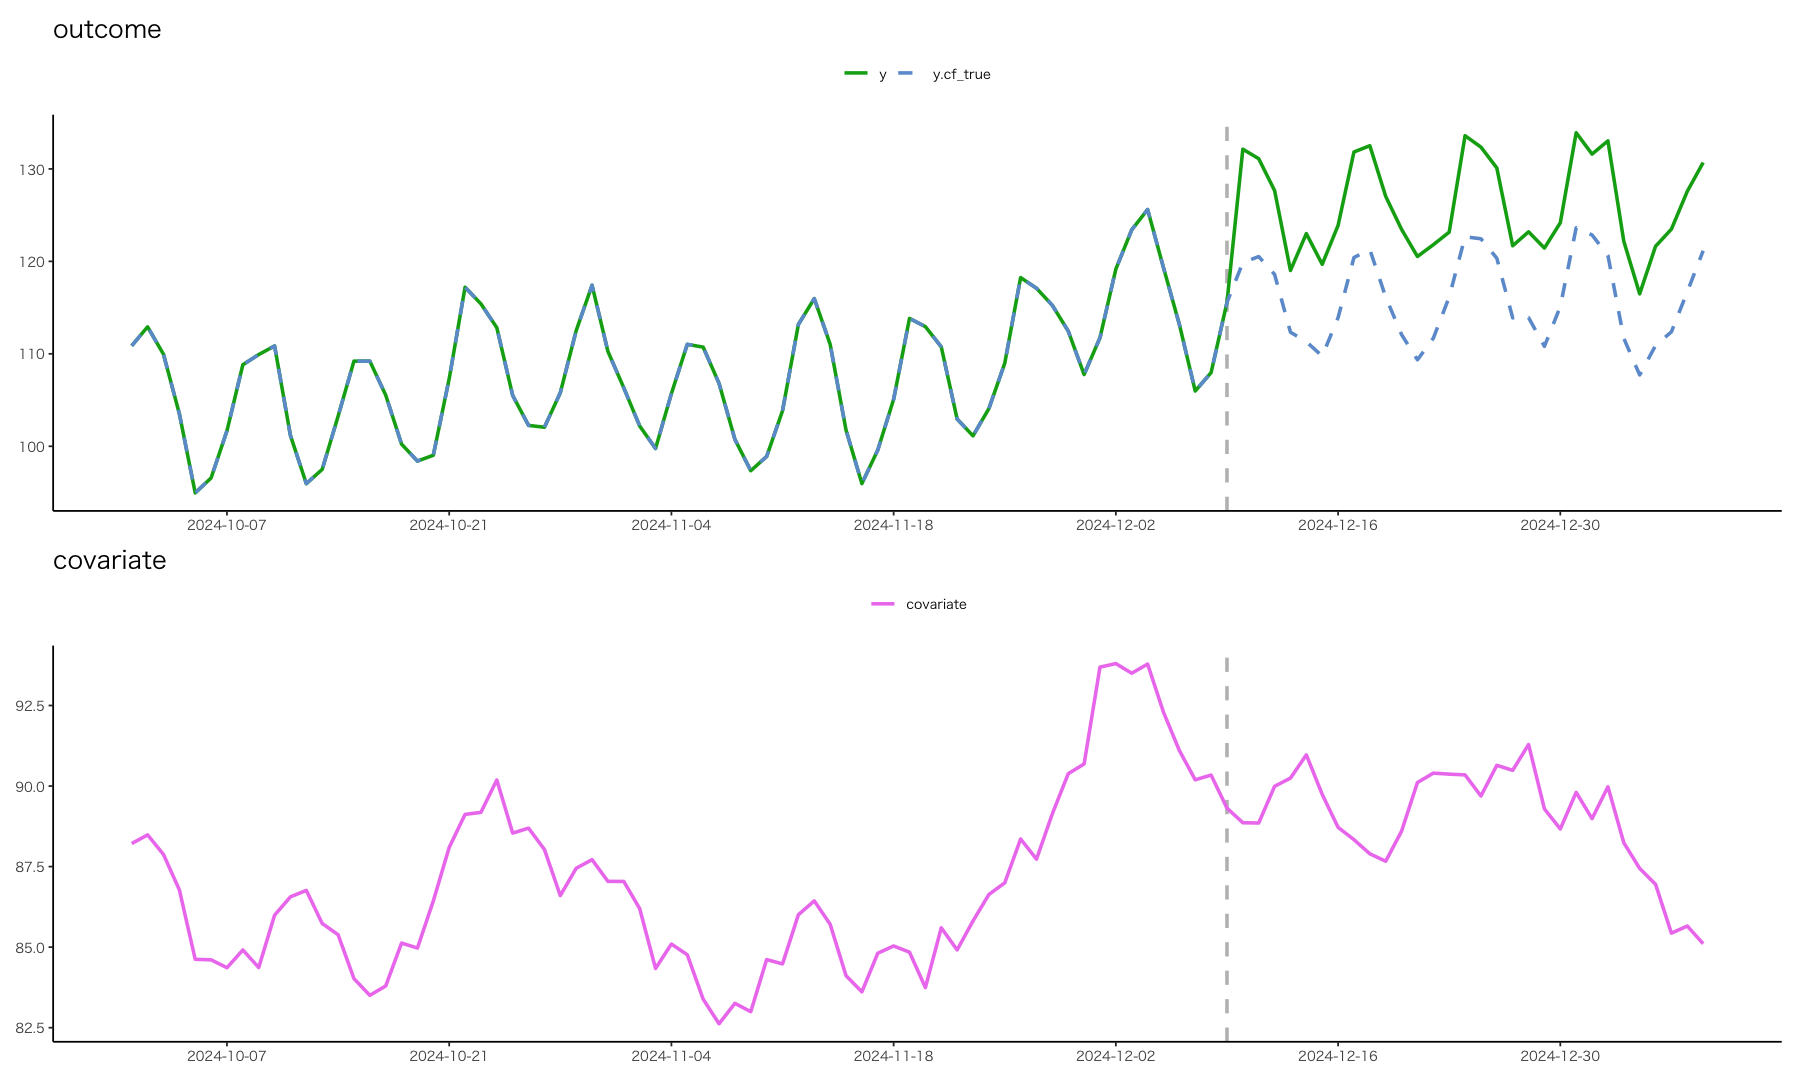

In [32]:
func_plot_check(df = data.pattern3_1)

In [33]:
# CausalImpactの実行
set.seed(1)
impact.pattern3_1 <- CausalImpact::CausalImpact(data = data.pattern3_1 |> dplyr::select(date, y, covariate)
																						    , pre.period = pre.period
																						    , post.period = post.period
																						   )

Posterior inference {CausalImpact}

                         Average      Cumulative  
Actual                   126          3784        
Prediction (s.d.)        111 (1.2)    3333 (35.2) 
95% CI                   [109, 113]   [3265, 3400]
                                                  
Absolute effect (s.d.)   15 (1.2)     451 (35.2)  
95% CI                   [13, 17]     [384, 519]  
                                                  
Relative effect (s.d.)   14% (1.2%)   14% (1.2%)  
95% CI                   [11%, 16%]   [11%, 16%]  

Posterior tail-area probability p:   0.001
Posterior prob. of a causal effect:  99.9%

For more details, type: summary(impact, "report")



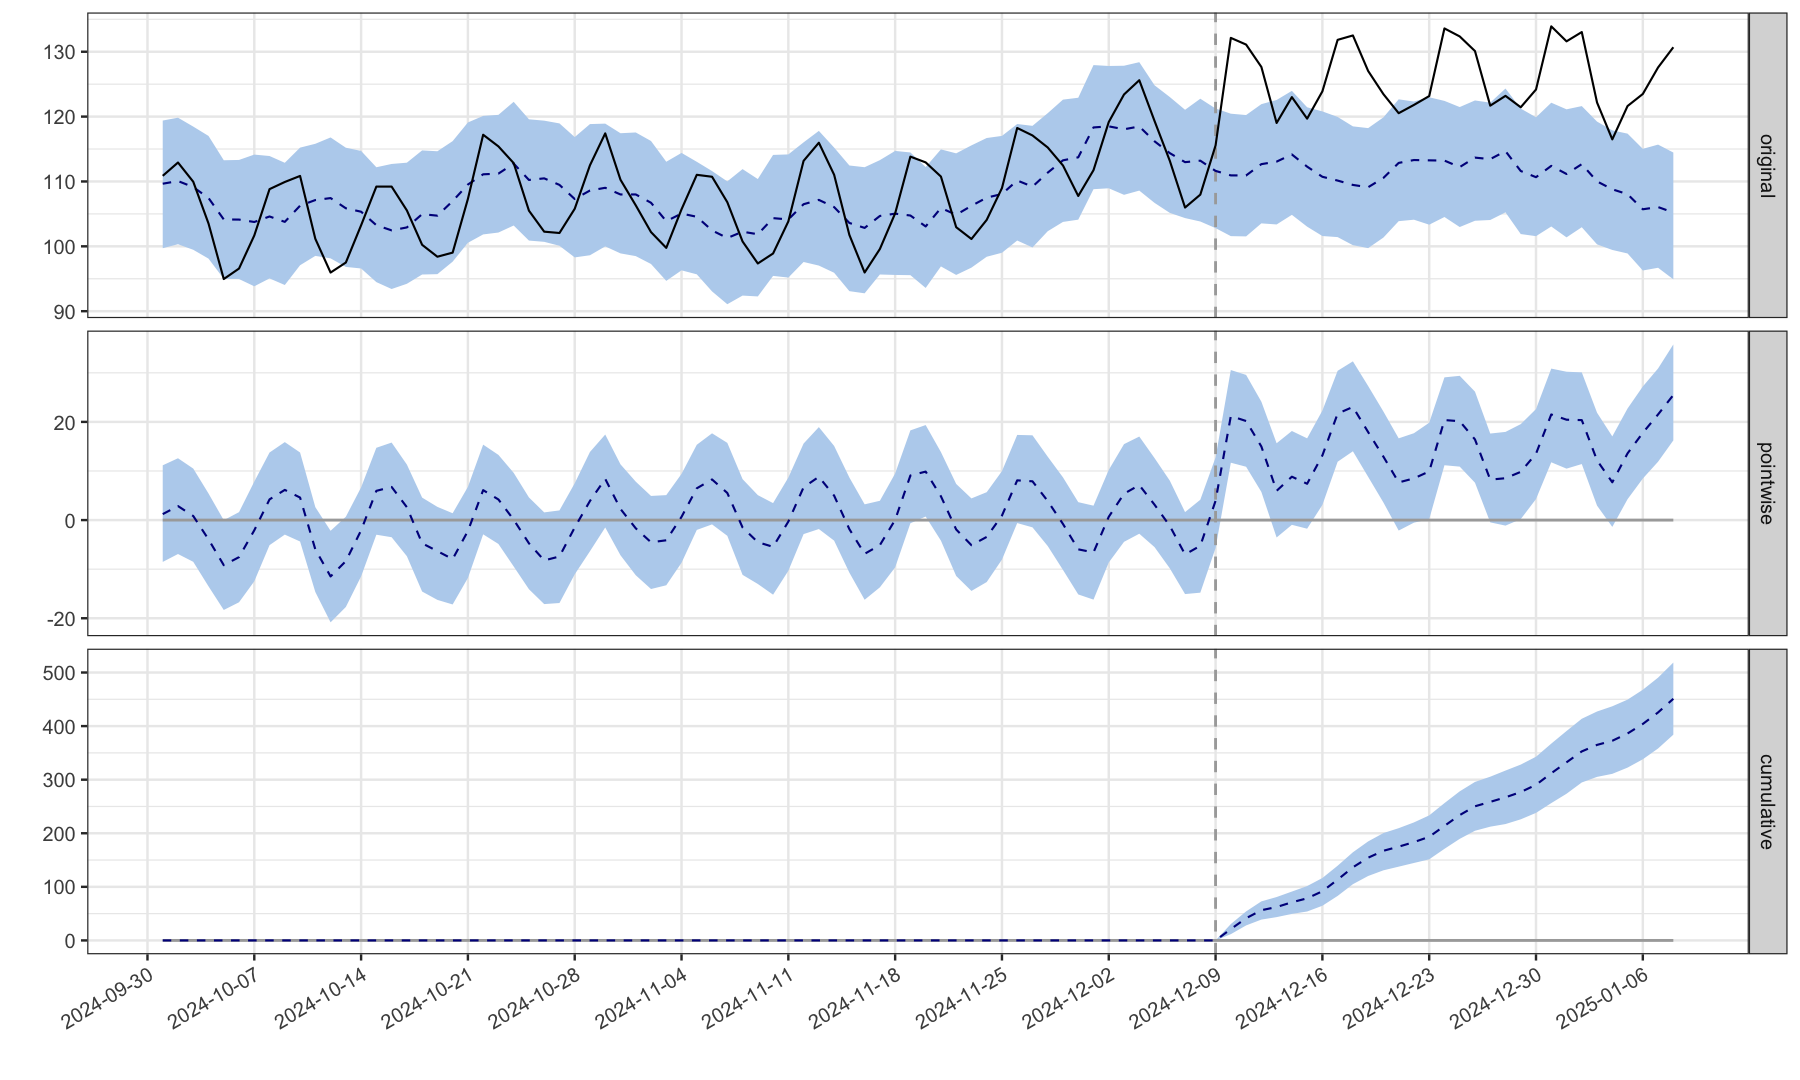

In [34]:
# CausalImpactの結果確認
summary(impact.pattern3_1)
plot(impact.pattern3_1) +
  scale_x_date(date_breaks = '1 week'
               , date_labels = '%Y-%m-%d'
               , minor_breaks = '1 week'
              ) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1))

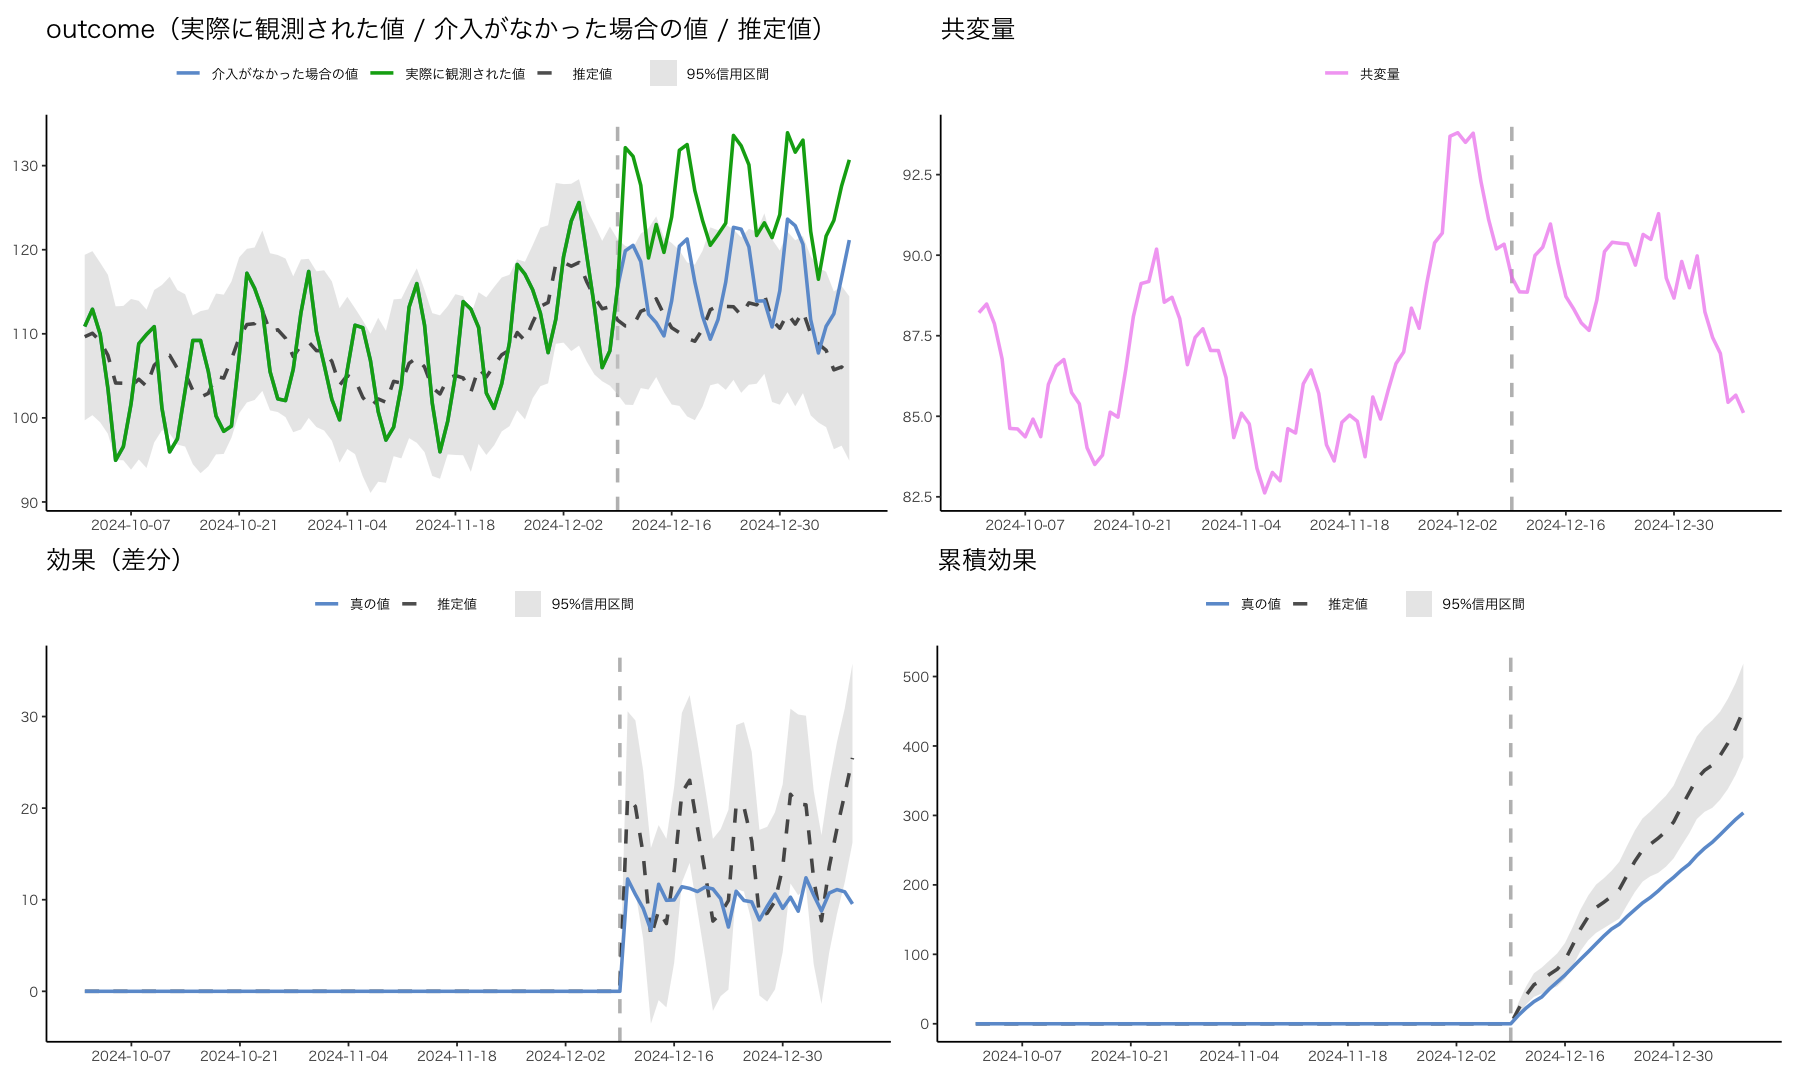

In [35]:
func_plot_CIresult_diff_trueEffect(data = data.pattern3_1
                                   , impact = impact.pattern3_1
                                   , pre_end_date = pre_end_date
                                  )

### アンチパターン 3の解決策 1 - 周期性を指定するパラメータを設定

In [36]:
data.pattern3_2 <- data.pattern3_1

In [37]:
# CausalImpactの実行
set.seed(1)
impact.pattern3_2 <- CausalImpact::CausalImpact(data = data.pattern3_2 |> dplyr::select(date, y, covariate)
																						    , pre.period = pre.period
																						    , post.period = post.period
																								, model.args = list(nseasons = 7)  ## 週次の周期性を考慮
																						   )

Posterior inference {CausalImpact}

                         Average       Cumulative  
Actual                   126           3784        
Prediction (s.d.)        112 (0.72)    3354 (21.53)
95% CI                   [110, 113]    [3313, 3397]
                                                   
Absolute effect (s.d.)   14 (0.72)     430 (21.53) 
95% CI                   [13, 16]      [387, 471]  
                                                   
Relative effect (s.d.)   13% (0.72%)   13% (0.72%) 
95% CI                   [11%, 14%]    [11%, 14%]  

Posterior tail-area probability p:   0.00104
Posterior prob. of a causal effect:  99.89551%

For more details, type: summary(impact, "report")



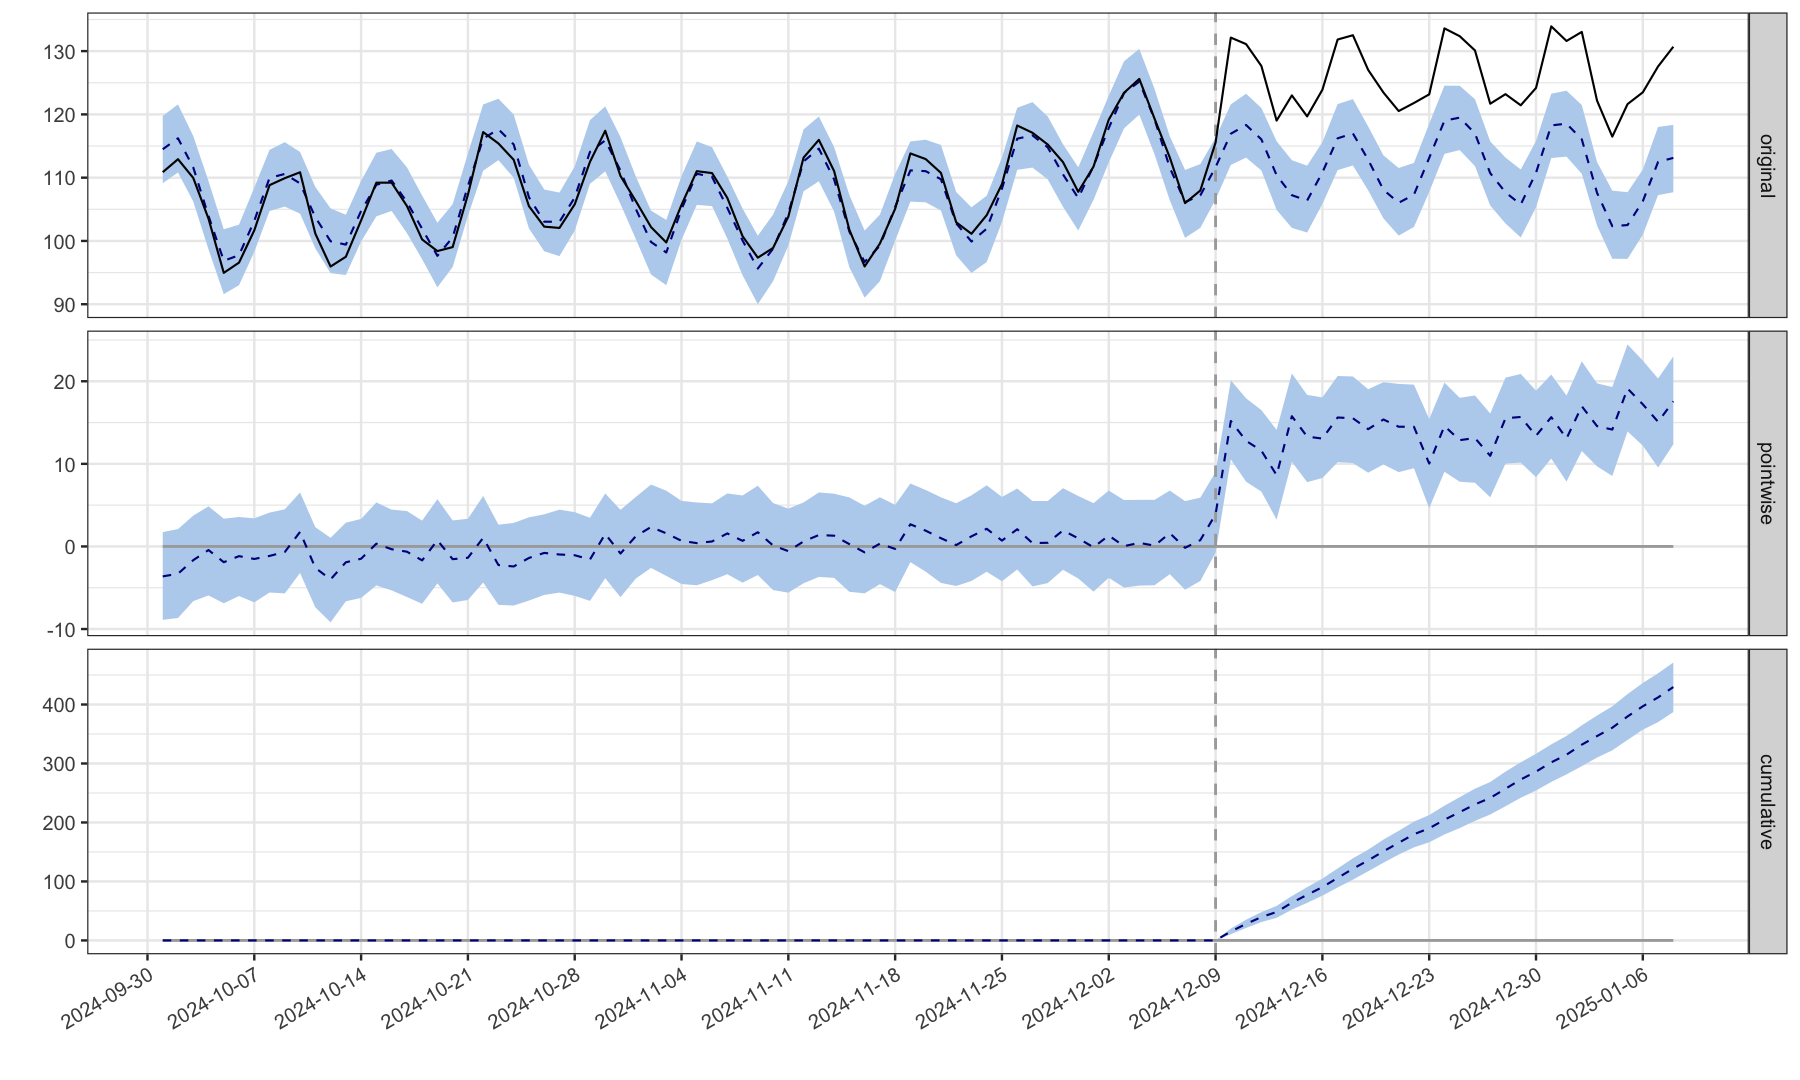

In [38]:
# CausalImpactの結果確認
summary(impact.pattern3_2)
plot(impact.pattern3_2) +
  scale_x_date(date_breaks = '1 week'
               , date_labels = '%Y-%m-%d'
               , minor_breaks = '1 week'
              ) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1))

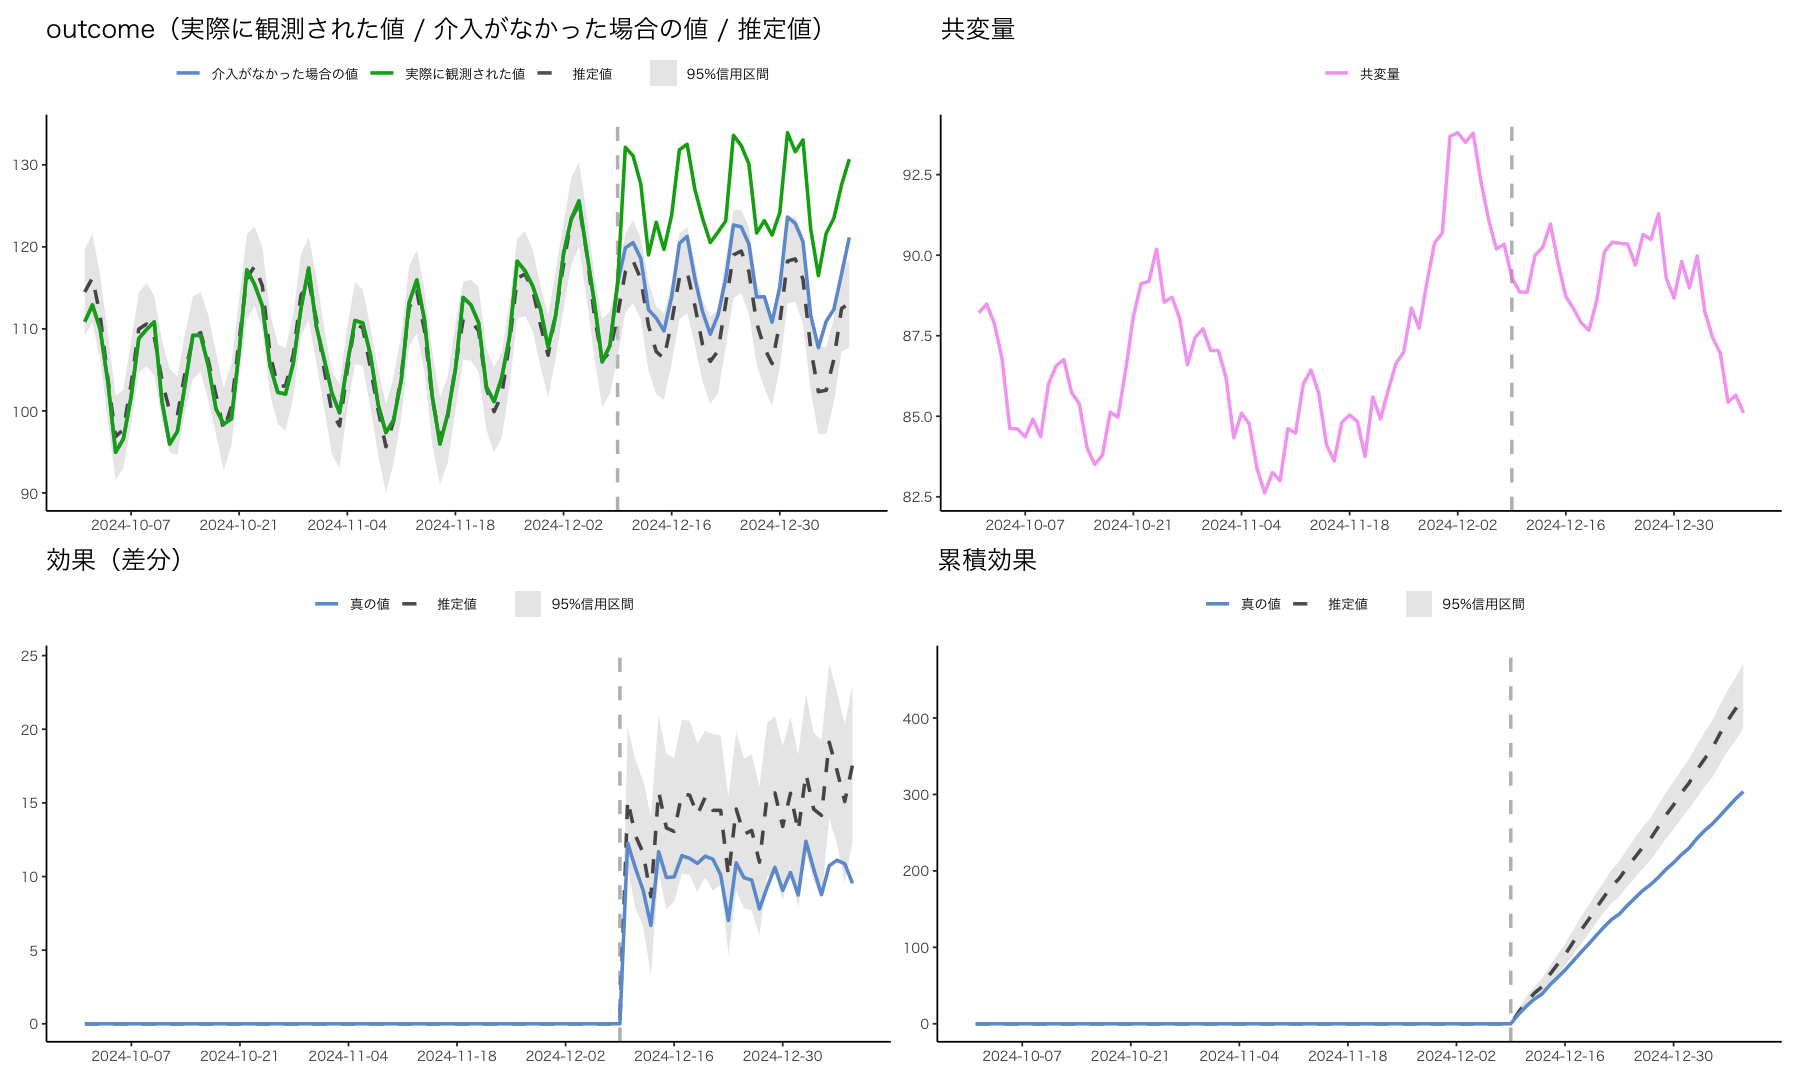

In [41]:
func_plot_CIresult_diff_trueEffect(data = data.pattern3_2
                                   , impact = impact.pattern3_2
                                   , pre_end_date = pre_end_date
                                  )

### アンチパターン 3の解決策 2 - 同じような周期性がある共変量を選択

In [42]:
data.pattern3_3 <- data.pattern3_1 |>
	dplyr::mutate(covariate = covariate + weekly_seasonal_effect + trend_effect) |>
	dplyr::select(date, y.cf_true, y, covariate)

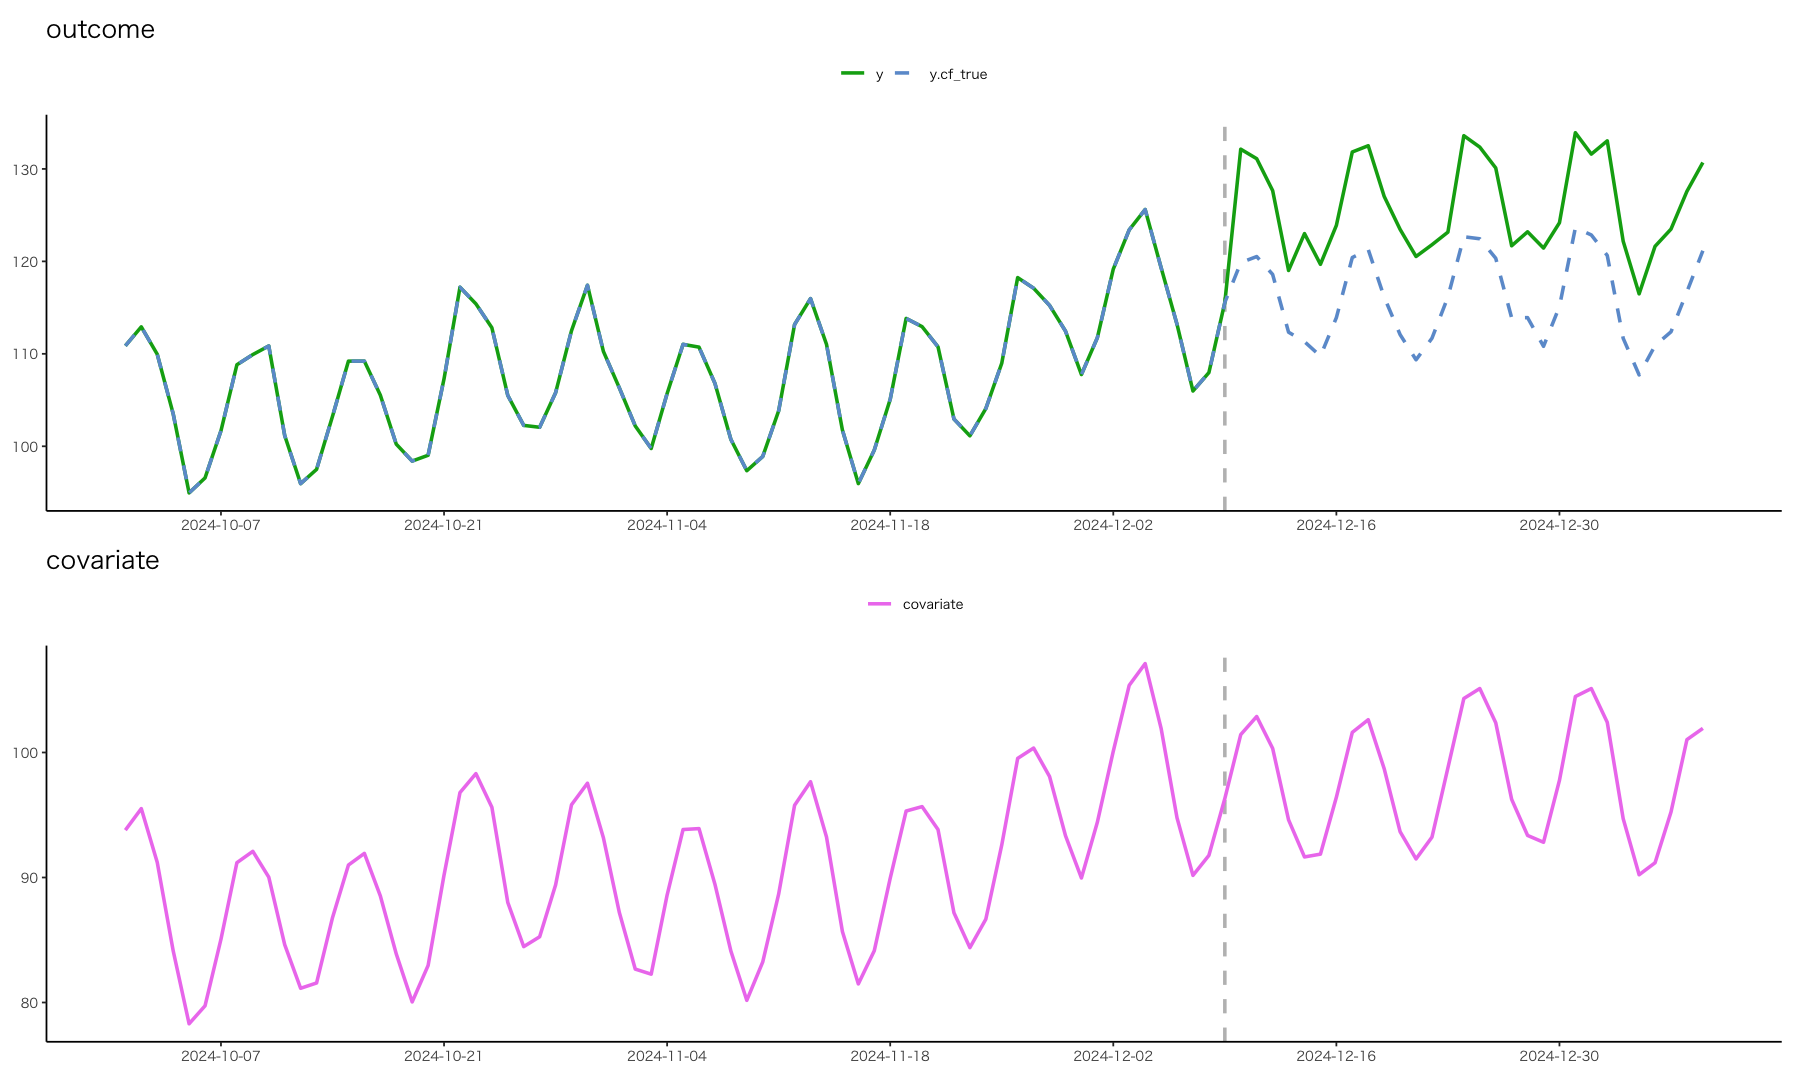

In [43]:
func_plot_check(df = data.pattern3_3)

In [44]:
# CausalImpactの実行
set.seed(1)
impact.pattern3_3 <- CausalImpact::CausalImpact(data = data.pattern3_3 |> dplyr::select(date, y, covariate)
																						    , pre.period = pre.period
																						    , post.period = post.period
																						   )

Posterior inference {CausalImpact}

                         Average       Cumulative  
Actual                   126           3784        
Prediction (s.d.)        116 (0.65)    3473 (19.48)
95% CI                   [115, 117]    [3436, 3512]
                                                   
Absolute effect (s.d.)   10 (0.65)     311 (19.48) 
95% CI                   [9.1, 12]     [271.9, 348]
                                                   
Relative effect (s.d.)   9% (0.61%)    9% (0.61%)  
95% CI                   [7.7%, 10%]   [7.7%, 10%] 

Posterior tail-area probability p:   0.00101
Posterior prob. of a causal effect:  99.8993%

For more details, type: summary(impact, "report")



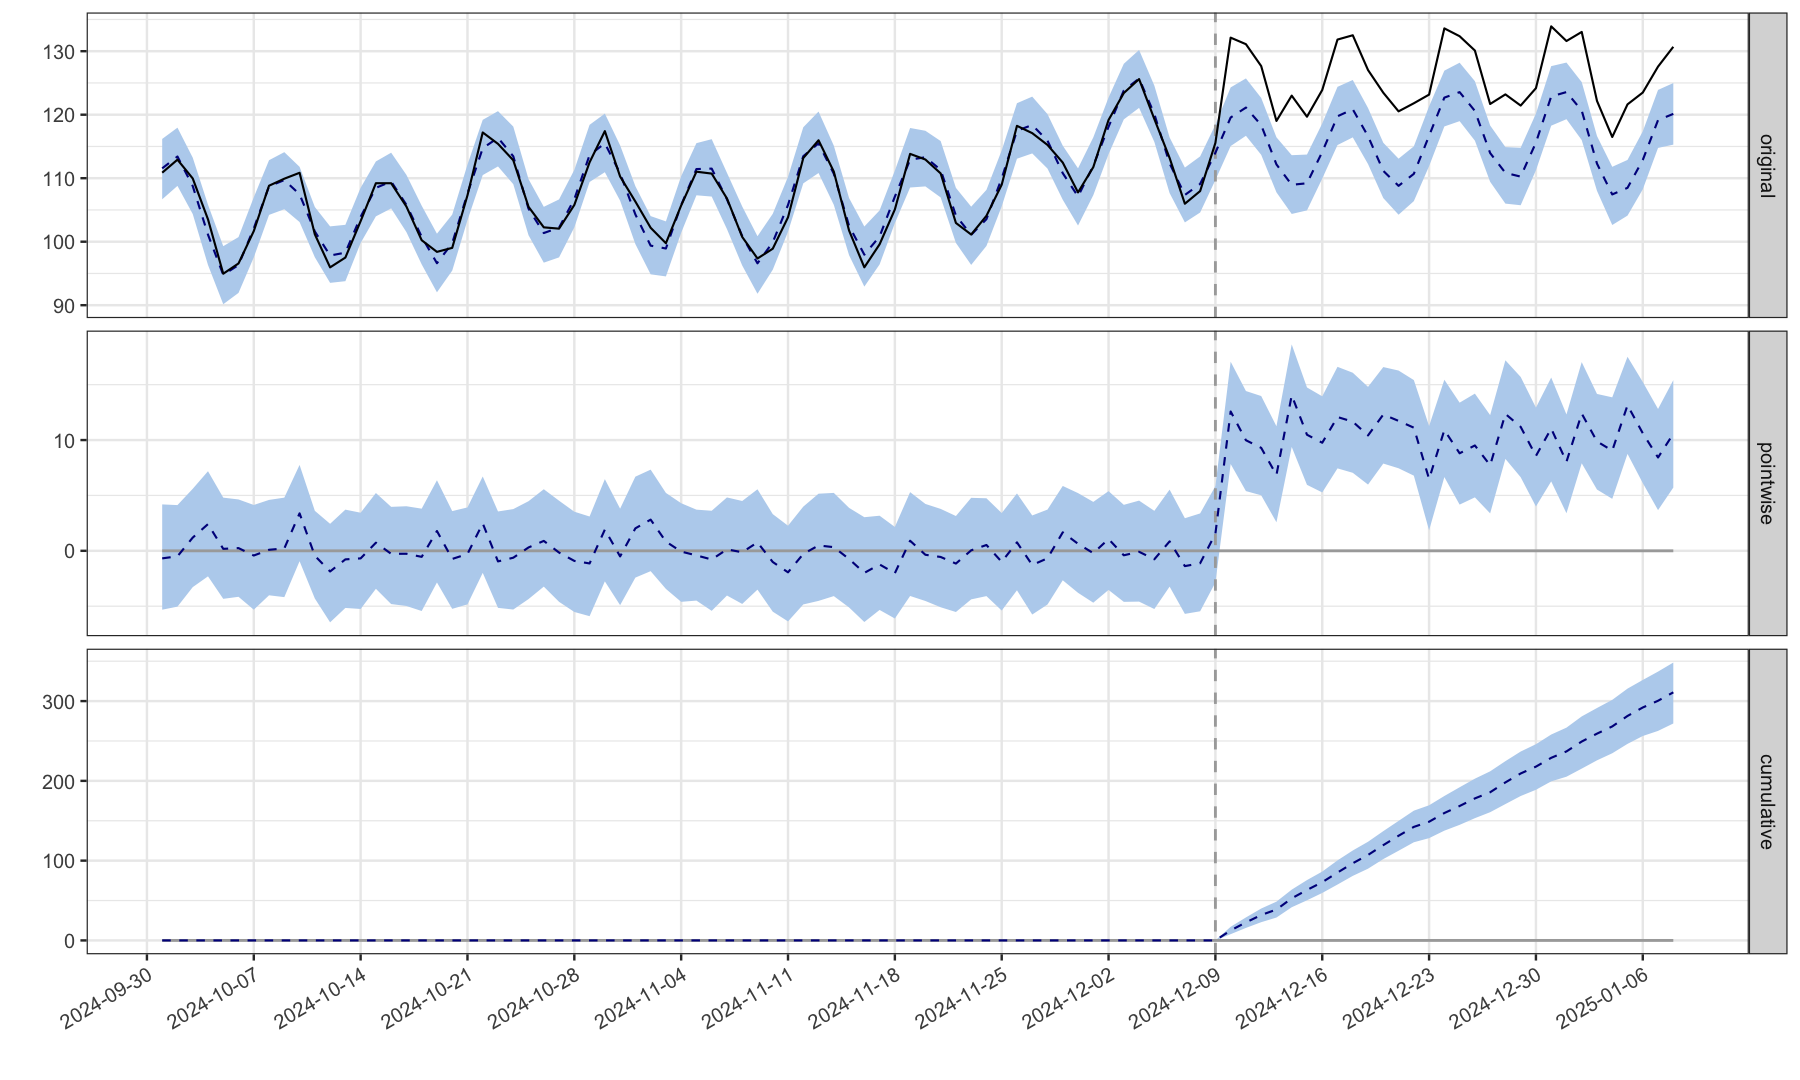

In [45]:
# CausalImpactの結果確認
summary(impact.pattern3_3)
plot(impact.pattern3_3) +
  scale_x_date(date_breaks = '1 week'
               , date_labels = '%Y-%m-%d'
               , minor_breaks = '1 week'
              ) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1))

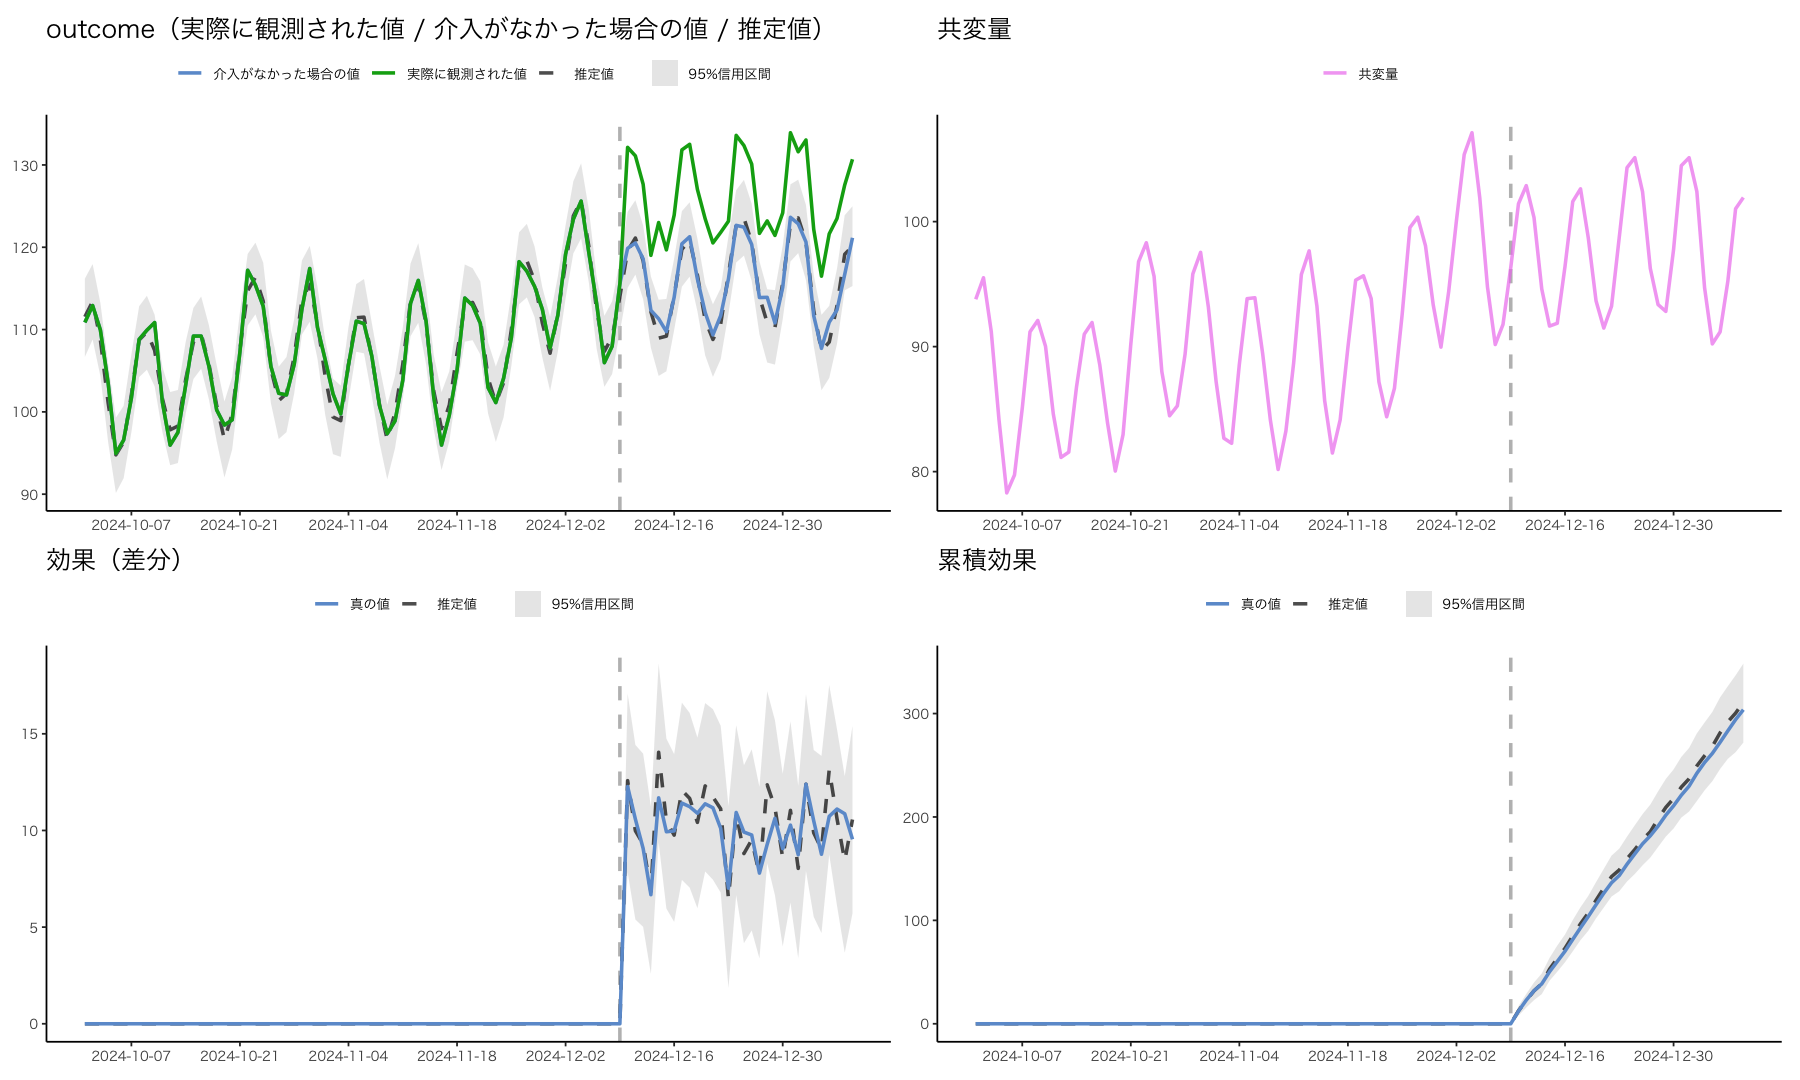

In [46]:
func_plot_CIresult_diff_trueEffect(data = data.pattern3_3
                                   , impact = impact.pattern3_3
                                   , pre_end_date = pre_end_date
                                  )